In [1]:
import modeller
import fitter

import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [13, 8]

In [3]:
p_true = [1, 3]
tspan = [0, 20]
def system(t, y, p):
    return [
        p[0]*y[1]*(p[1]-y[0]),
        -p[0]*y[0]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [0.5, 0.5], dense_output=True)

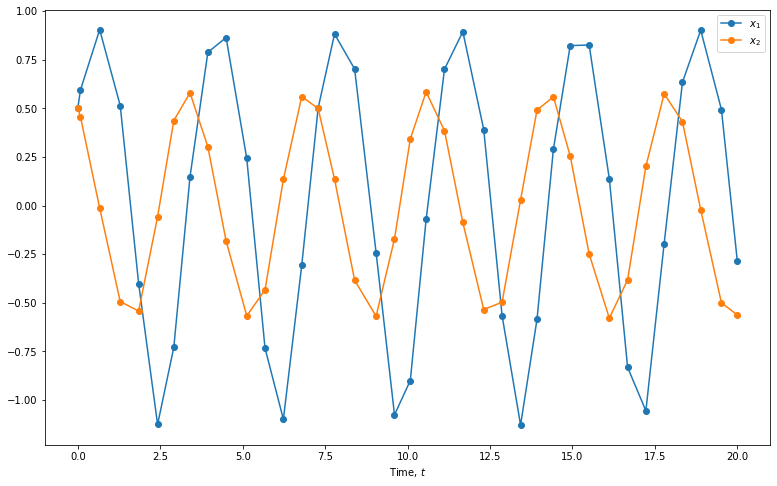

In [4]:
plt.plot(sol.t, sol.y.T, 'o-')
# plt.title("Synthetic Data (True Trajectories)")
plt.xlabel("Time, $t$")
plt.legend(["$x_1$", "$x_2$"])

In [5]:
neat_ts = np.linspace(*tspan, 15)
raw_data = sol.sol(neat_ts)[0]
data = raw_data + np.random.randn(15)*0.175
data.shape

(15,)

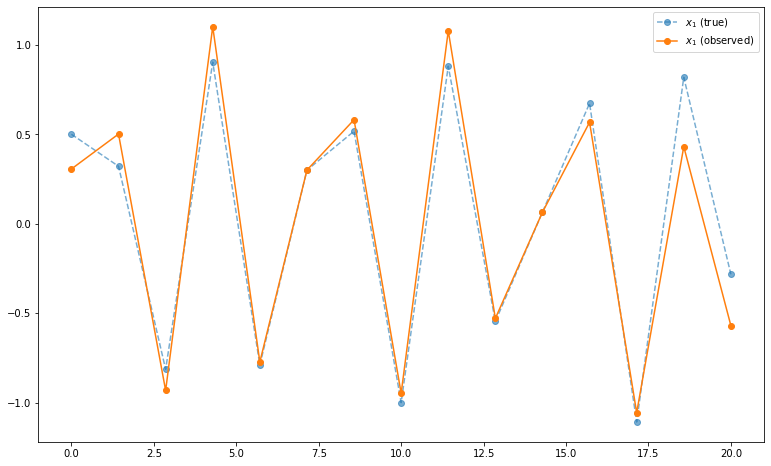

In [6]:
plt.plot(neat_ts, raw_data.T, 'o--', alpha=0.6, label="$x_1$ (true)")
plt.plot(neat_ts, data.T, 'o-', label="$x_1$ (observed)")
# plt.title("Synthetic Data")
plt.legend()

In [7]:
data_pd = np.array([[i] for i in list(data.flatten())])
# data_pd = np.array([list(i) for i in data.T])
config = {
    "grid_size": 100,
    "basis_number": 40,
    "model_form": {
        "state": 2,
        "parameters": 2
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": data_pd, "t": neat_ts},
    "observation_vector": [0],
    "weightings":[
        [1]*2,
        [1]*len(neat_ts)
    ],
    "regularisation_value": [0, 0],
}

In [8]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha])
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

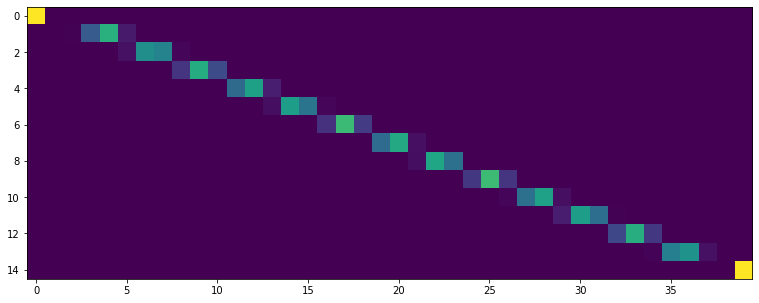

In [30]:
plt.imshow(objective.collocation_matrices[0])

In [9]:
p0 = [0.5, 1]
c0 = np.ones(config['basis_number']*2)
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*2) + [0]*len(config['regularisation_value'])

In [10]:
prange = np.logspace(-6, 6, num=200)
solutions = []
xguess = x0
for p in prange:
    solutions.append(solver(x0=xguess, p=[p, (np.log10(p)+6)*1e-4], lbx=lbx))
#     solutions.append(solver(x0=xguess, p=[p, 0], lbx=lbx))
    xguess = np.array(solutions[-1]['x']).flatten()
#     xguess += np.random.randn()*np.mean(xguess)/40


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3403

Total number of variables............................:       82
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

   6  2.6535934e-06 0.00e+00 4.77e-05  -8.6 9.72e-02  -5.9 1.00e+00 1.00e+00f  1
   7  1.9037125e-06 0.00e+00 2.70e-05  -8.6 1.66e-01  -6.4 1.00e+00 1.00e+00f  1
   8  1.6869864e-06 0.00e+00 1.18e-05  -8.6 1.88e-01  -6.9 1.00e+00 1.00e+00f  1
   9  1.6376370e-06 0.00e+00 2.69e-06  -8.6 1.02e-01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6281299e-06 0.00e+00 2.27e-07  -8.6 2.67e-02  -7.8 1.00e+00 1.00e+00f  1
  11  1.6261283e-06 0.00e+00 5.82e-09  -8.6 3.89e-03  -8.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.6261283486528071e-06    1.6261283486528071e-06
Dual infeasibility......:   5.8162822888471234e-09    5.8162822888471234e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8782990646977562e-09    2.8782990646977562e-09
Overall NLP error......

  17  1.5017447e-03 0.00e+00 1.45e+01  -2.5 1.27e+00  -5.2 1.00e+00 1.00e+00f  1
  18  1.5318526e-03 0.00e+00 7.48e+00  -2.5 1.11e+00  -5.7 1.00e+00 1.00e+00f  1
  19  1.5525900e-03 0.00e+00 3.93e+00  -2.5 7.04e-01  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5741280e-03 0.00e+00 1.77e-01  -2.5 2.44e-01  -6.6 1.00e+00 1.00e+00f  1
  21  5.7797754e-04 0.00e+00 2.23e+02  -3.8 1.27e+00  -7.1 1.00e+00 1.00e+00f  1
  22  2.1988779e-04 0.00e+00 1.40e+02  -3.8 1.66e+00  -7.6 1.00e+00 1.00e+00f  1
  23  1.0548533e-04 0.00e+00 2.50e+01  -3.8 6.48e-01  -8.1 1.00e+00 1.00e+00f  1
  24  1.0383702e-04 0.00e+00 6.57e+00  -3.8 8.67e-01  -8.5 1.00e+00 1.00e+00f  1
  25  1.0936843e-04 0.00e+00 1.55e-01  -3.8 6.83e-01  -9.0 1.00e+00 1.00e+00f  1
  26  1.0927503e-04 0.00e+00 4.39e-05  -3.8 2.39e-01  -9.5 1.00e+00 1.00e+00f  1
  27  4.2239749e-05 0.00e+00 2.96e+01  -5.7 8.05e-01 -10.0 1.00e+00 1.00e+00f  1
  28  1.4657441e-05 0.00e+00

  13  2.2111680e-04 0.00e+00 1.24e+00  -3.8 4.74e-02  -1.7 1.00e+00 1.00e+00f  1
  14  1.2536587e-04 0.00e+00 3.35e+00  -3.8 7.90e-02  -2.2 1.00e+00 1.00e+00f  1
  15  9.5134756e-05 0.00e+00 6.13e+00  -3.8 1.19e-01  -2.7 1.00e+00 1.00e+00f  1
  16  8.9569187e-05 0.00e+00 5.33e+00  -3.8 1.50e-01  -3.2 1.00e+00 1.00e+00f  1
  17  9.2728301e-05 0.00e+00 1.47e+00  -3.8 1.53e-01  -3.6 1.00e+00 1.00e+00f  1
  18  9.8937478e-05 0.00e+00 5.00e-01  -3.8 1.05e-01  -4.1 1.00e+00 1.00e+00f  1
  19  1.0119476e-04 0.00e+00 1.98e-01  -3.8 1.59e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.8714085e-05 0.00e+00 5.81e-01  -3.8 4.43e-01  -5.1 1.00e+00 1.00e+00f  1
  21  1.0301859e-04 0.00e+00 1.39e+01  -3.8 9.41e-01  -5.5 1.00e+00 1.00e+00f  1
  22  1.1088258e-04 0.00e+00 4.53e+00  -3.8 6.19e-01  -6.0 1.00e+00 1.00e+00f  1
  23  1.1358986e-04 0.00e+00 8.79e-01  -3.8 3.07e-01  -6.5 1.00e+00 1.00e+00f  1
  24  1.1405802e-04 0.00e+00

  11  1.0059168e-04 0.00e+00 9.84e-02  -3.8 1.61e-02  -0.8 1.00e+00 1.00e+00f  1
  12  9.7542340e-05 0.00e+00 3.04e-01  -3.8 2.84e-02  -1.2 1.00e+00 1.00e+00f  1
  13  9.2298116e-05 0.00e+00 8.88e-01  -3.8 4.87e-02  -1.7 1.00e+00 1.00e+00f  1
  14  8.7666310e-05 0.00e+00 2.24e+00  -3.8 7.98e-02  -2.2 1.00e+00 1.00e+00f  1
  15  8.7300662e-05 0.00e+00 3.92e+00  -3.8 1.18e-01  -2.7 1.00e+00 1.00e+00f  1
  16  9.0513089e-05 0.00e+00 3.22e+00  -3.8 1.45e-01  -3.2 1.00e+00 1.00e+00f  1
  17  9.6857096e-05 0.00e+00 9.85e-01  -3.8 1.39e-01  -3.6 1.00e+00 1.00e+00f  1
  18  1.0396038e-04 0.00e+00 4.65e-01  -3.8 8.21e-02  -4.1 1.00e+00 1.00e+00f  1
  19  1.0453828e-04 0.00e+00 1.98e-01  -3.8 1.60e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0289338e-04 0.00e+00 7.88e-01  -3.8 4.42e-01  -5.1 1.00e+00 1.00e+00f  1
  21  1.0905931e-04 0.00e+00 8.34e+00  -3.8 8.62e-01  -5.5 1.00e+00 1.00e+00f  1
  22  1.1609173e-04 0.00e+00

  13  1.1404819e-04 0.00e+00 1.02e+00  -3.8 4.87e-02  -1.7 1.00e+00 1.00e+00f  1
  14  9.6696174e-05 0.00e+00 2.59e+00  -3.8 7.96e-02  -2.2 1.00e+00 1.00e+00f  1
  15  9.1652824e-05 0.00e+00 4.50e+00  -3.8 1.17e-01  -2.7 1.00e+00 1.00e+00f  1
  16  9.4376180e-05 0.00e+00 3.65e+00  -3.8 1.41e-01  -3.2 1.00e+00 1.00e+00f  1
  17  1.0119950e-04 0.00e+00 1.12e+00  -3.8 1.28e-01  -3.6 1.00e+00 1.00e+00f  1
  18  1.0793522e-04 0.00e+00 4.56e-01  -3.8 6.77e-02  -4.1 1.00e+00 1.00e+00f  1
  19  1.0800728e-04 0.00e+00 1.74e-01  -3.8 1.64e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0680692e-04 0.00e+00 1.09e+00  -3.8 4.40e-01  -5.1 1.00e+00 1.00e+00f  1
  21  1.1386729e-04 0.00e+00 8.45e+00  -3.8 8.05e-01  -5.5 1.00e+00 1.00e+00f  1
  22  1.2057358e-04 0.00e+00 2.40e+00  -3.8 4.90e-01  -6.0 1.00e+00 1.00e+00f  1
  23  1.2244950e-04 0.00e+00 3.21e-01  -3.8 1.93e-01  -6.5 1.00e+00 1.00e+00f  1
  24  1.2268635e-04 0.00e+00

  13  1.1448247e-04 0.00e+00 1.01e+00  -3.8 4.86e-02  -1.7 1.00e+00 1.00e+00f  1
  14  9.8310315e-05 0.00e+00 2.56e+00  -3.8 7.93e-02  -2.2 1.00e+00 1.00e+00f  1
  15  9.4200336e-05 0.00e+00 4.40e+00  -3.8 1.15e-01  -2.7 1.00e+00 1.00e+00f  1
  16  9.7982294e-05 0.00e+00 3.50e+00  -3.8 1.36e-01  -3.2 1.00e+00 1.00e+00f  1
  17  1.0551364e-04 0.00e+00 1.10e+00  -3.8 1.18e-01  -3.6 1.00e+00 1.00e+00f  1
  18  1.1198478e-04 0.00e+00 3.89e-01  -3.8 6.39e-02  -4.1 1.00e+00 1.00e+00f  1
  19  1.1155841e-04 0.00e+00 1.74e-01  -3.8 1.66e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1091768e-04 0.00e+00 1.25e+00  -3.8 4.32e-01  -5.1 1.00e+00 1.00e+00f  1
  21  1.1858705e-04 0.00e+00 7.17e+00  -3.8 7.43e-01  -5.5 1.00e+00 1.00e+00f  1
  22  1.2495942e-04 0.00e+00 1.95e+00  -3.8 4.33e-01  -6.0 1.00e+00 1.00e+00f  1
  23  1.2652108e-04 0.00e+00 2.09e-01  -3.8 1.51e-01  -6.5 1.00e+00 1.00e+00f  1
  24  1.2670161e-04 0.00e+00

   5  9.6808362e-03 0.00e+00 1.36e-01  -2.5 1.10e-03   2.1 1.00e+00 1.00e+00f  1
   6  2.4659421e-03 0.00e+00 8.26e-03  -3.8 1.99e-04   1.6 1.00e+00 1.00e+00f  1
   7  6.6398342e-04 0.00e+00 9.48e-03  -3.8 6.89e-04   1.1 1.00e+00 1.00e+00f  1
   8  2.1563097e-04 0.00e+00 1.11e-02  -3.8 1.82e-03   0.7 1.00e+00 1.00e+00f  1
   9  1.0850925e-04 0.00e+00 1.33e-02  -3.8 4.24e-03   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.9568741e-05 0.00e+00 2.54e-02  -3.8 8.50e-03  -0.3 1.00e+00 1.00e+00f  1
  11  8.8478255e-05 0.00e+00 8.34e-02  -3.8 1.58e-02  -0.8 1.00e+00 1.00e+00f  1
  12  8.8414893e-05 0.00e+00 2.64e-01  -3.8 2.81e-02  -1.2 1.00e+00 1.00e+00f  1
  13  8.8534630e-05 0.00e+00 7.66e-01  -3.8 4.82e-02  -1.7 1.00e+00 1.00e+00f  1
  14  8.9853843e-05 0.00e+00 1.89e+00  -3.8 7.84e-02  -2.2 1.00e+00 1.00e+00f  1
  15  9.4069940e-05 0.00e+00 3.14e+00  -3.8 1.13e-01  -2.7 1.00e+00 1.00e+00f  1
  16  1.0114553e-04 0.00e+00

   8  2.3757888e-04 0.00e+00 2.59e-02  -3.8 2.13e-03   0.7 1.00e+00 1.00e+00f  1
   9  1.2701215e-04 0.00e+00 2.74e-02  -3.8 4.61e-03   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0692432e-04 0.00e+00 3.66e-02  -3.8 8.84e-03  -0.3 1.00e+00 1.00e+00f  1
  11  1.0487585e-04 0.00e+00 9.92e-02  -3.8 1.61e-02  -0.8 1.00e+00 1.00e+00f  1
  12  1.0269576e-04 0.00e+00 3.07e-01  -3.8 2.83e-02  -1.2 1.00e+00 1.00e+00f  1
  13  9.9030787e-05 0.00e+00 8.87e-01  -3.8 4.85e-02  -1.7 1.00e+00 1.00e+00f  1
  14  9.6506374e-05 0.00e+00 2.19e+00  -3.8 7.85e-02  -2.2 1.00e+00 1.00e+00f  1
  15  9.8979020e-05 0.00e+00 3.64e+00  -3.8 1.12e-01  -2.7 1.00e+00 1.00e+00f  1
  16  1.0602202e-04 0.00e+00 2.74e+00  -3.8 1.28e-01  -3.2 1.00e+00 1.00e+00f  1
  17  1.1478909e-04 0.00e+00 8.93e-01  -3.8 1.00e-01  -3.6 1.00e+00 1.00e+00f  1
  18  1.2058936e-04 0.00e+00 2.56e-01  -3.8 6.71e-02  -4.1 1.00e+00 1.00e+00f  1
  19  1.1962553e-04 0.00e+00

  16  1.1197460e-04 0.00e+00 3.12e+00  -3.8 1.24e-01  -3.2 1.00e+00 1.00e+00f  1
  17  1.2046852e-04 0.00e+00 9.62e-01  -3.8 9.35e-02  -3.6 1.00e+00 1.00e+00f  1
  18  1.2654994e-04 0.00e+00 1.85e-01  -3.8 7.02e-02  -4.1 1.00e+00 1.00e+00f  1
  19  1.2481586e-04 0.00e+00 2.27e-01  -3.8 1.66e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2586946e-04 0.00e+00 1.29e+00  -3.8 3.79e-01  -5.1 1.00e+00 1.00e+00f  1
  21  1.3380960e-04 0.00e+00 3.54e+00  -3.8 5.34e-01  -5.5 1.00e+00 1.00e+00f  1
  22  1.3884713e-04 0.00e+00 8.13e-01  -3.8 2.67e-01  -6.0 1.00e+00 1.00e+00f  1
  23  1.3973452e-04 0.00e+00 4.03e-02  -3.8 6.16e-02  -6.5 1.00e+00 1.00e+00f  1
  24  1.3981168e-04 0.00e+00 4.02e-04  -3.8 6.00e-03  -7.0 1.00e+00 1.00e+00f  1
  25  5.6899911e-05 0.00e+00 1.33e+01  -5.7 6.99e-01  -7.5 1.00e+00 1.00e+00f  1
  26  2.6314772e-05 0.00e+00 4.36e+00  -5.7 5.77e-01  -7.9 1.00e+00 1.00e+00f  1
  27  1.8465742e-05 0.00e+00

  28  2.1434758e-05 0.00e+00 2.15e-01  -5.7 3.93e-02  -8.9 1.00e+00 1.00e+00f  1
  29  2.1230552e-05 0.00e+00 4.05e-03  -5.7 4.42e-03  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1225805e-05 0.00e+00 2.02e-06  -5.7 9.36e-05  -9.8 1.00e+00 1.00e+00f  1
  31  1.9930017e-05 0.00e+00 9.69e-02  -8.6 4.20e-02 -10.3 1.00e+00 1.00e+00f  1
  32  1.9610595e-05 0.00e+00 2.13e-02  -8.6 2.20e-02 -10.8 1.00e+00 1.00e+00f  1
  33  1.9539670e-05 0.00e+00 1.11e-03  -8.6 1.07e-02 -11.3 1.00e+00 1.00e+00f  1
  34  1.9524980e-05 0.00e+00 1.43e-04  -8.6 5.11e-03 -11.7 1.00e+00 1.00e+00f  1
  35  1.9522040e-05 0.00e+00 2.57e-05  -8.6 2.15e-03 -12.2 1.00e+00 1.00e+00f  1
  36  1.9521504e-05 0.00e+00 2.11e-07  -8.6 6.00e-04 -12.7 1.00e+00 1.00e+00f  1
  37  1.9521460e-05 0.00e+00 9.49e-09  -8.6 1.05e-04 -13.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objecti

  37  2.5717030e-05 0.00e+00 1.24e-08  -8.6 8.99e-05 -13.2 1.00e+00 1.00e+00f  1
  38  2.5716337e-05 0.00e+00 7.77e-06  -9.0 9.65e-04 -13.7 1.00e+00 1.00e+00f  1
  39  2.5716222e-05 0.00e+00 1.31e-07  -9.0 2.81e-04 -14.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.5716215e-05 0.00e+00 7.30e-10  -9.0 8.44e-04 -14.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   2.5716215386683612e-05    2.5716215386683612e-05
Dual infeasibility......:   7.2998164457604986e-10    7.2998164457604986e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0914284902639912e-10    9.0914284902639912e-10
Overall NLP error.......:   9.0914284902639912e-10    9.0914284902639912e-10


Number of objective function evaluations             = 41
Number of objective gradient evaluations        

  37  3.3872327e-05 0.00e+00 1.52e-08  -8.6 5.13e-05 -12.7 1.00e+00 1.00e+00f  1
  38  3.3871652e-05 0.00e+00 6.69e-06  -9.0 9.25e-04 -13.2 1.00e+00 1.00e+00f  1
  39  3.3871539e-05 0.00e+00 1.94e-07  -9.0 2.14e-04 -13.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.3871532e-05 0.00e+00 9.02e-10  -9.0 2.64e-04 -14.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   3.3871532288999344e-05    3.3871532288999344e-05
Dual infeasibility......:   9.0211210723722957e-10    9.0211210723722957e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0914251482731505e-10    9.0914251482731505e-10
Overall NLP error.......:   9.0914251482731505e-10    9.0914251482731505e-10


Number of objective function evaluations             = 41
Number of objective gradient evaluations        

   3  2.7878811e-01 0.00e+00 2.12e+04  -1.0 1.14e-04   5.0 1.00e+00 5.00e-01f  2
   4  1.4535209e-01 0.00e+00 1.22e+01  -1.0 3.30e-04   4.6 1.00e+00 1.00e+00f  1
   5  3.7056965e-02 0.00e+00 3.12e-01  -2.5 2.50e-05   4.1 1.00e+00 1.00e+00f  1
   6  9.3255705e-03 0.00e+00 2.02e-02  -3.8 4.56e-06   3.6 1.00e+00 1.00e+00f  1
   7  2.3630497e-03 0.00e+00 3.18e-03  -5.7 2.29e-06   3.1 1.00e+00 1.00e+00f  1
   8  6.2612087e-04 0.00e+00 5.82e-04  -5.7 1.14e-06   2.7 1.00e+00 1.00e+00f  1
   9  1.9373383e-04 0.00e+00 2.48e-04  -5.7 1.55e-06   2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.6555193e-05 0.00e+00 2.32e-04  -5.7 4.51e-06   1.7 1.00e+00 1.00e+00f  1
  11  6.0213179e-05 0.00e+00 2.26e-04  -5.7 1.33e-05   1.2 1.00e+00 1.00e+00f  1
  12  5.3849031e-05 0.00e+00 2.73e-04  -5.7 3.94e-05   0.8 1.00e+00 1.00e+00f  1
  13  5.2381118e-05 0.00e+00 3.34e-04  -5.7 1.16e-04   0.3 1.00e+00 1.00e+00f  1
  14  5.2113618e-05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1180377e-05 0.00e+00 3.43e-05  -8.6 1.53e+04    -  1.00e+00 1.00e+00f  1
 101  5.1180377e-05 0.00e+00 2.66e-05  -8.6 1.34e+04    -  1.00e+00 1.00e+00f  1
 102  5.1180377e-05 0.00e+00 2.45e-05  -8.6 1.29e+04    -  1.00e+00 1.00e+00f  1
 103  5.1180378e-05 0.00e+00 1.08e-05  -8.6 8.53e+03    -  1.00e+00 1.00e+00f  1
 104  5.1180378e-05 0.00e+00 3.34e-05  -8.6 1.51e+04    -  1.00e+00 1.00e+00f  1
 105  5.1180378e-05 0.00e+00 1.18e-05  -8.6 8.88e+03    -  1.00e+00 1.00e+00f  1
 106  5.1180378e-05 0.00e+00 6.29e-06  -8.6 6.50e+03    -  1.00e+00 1.00e+00f  1
 107  5.1180378e-05 0.00e+00 5.03e-06  -8.6 5.81e+03    -  1.00e+00 1.00e+00f  1
 108  5.1180378e-05 0.00e+00 5.93e-06  -8.6 6.31e+03    -  1.00e+00 1.00e+00f  1
 109  5.1180378e-05 0.00e+00 7.35e-06  -8.6 7.02e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.1180378e-05 0.00e+00

 215  5.1180384e-05 0.00e+00 1.51e-05  -8.6 9.12e+03    -  1.00e+00 1.00e+00f  1
 216  5.1180384e-05 0.00e+00 1.63e-05  -8.6 9.45e+03    -  1.00e+00 1.00e+00f  1
 217  5.1180384e-05 0.00e+00 1.38e-05  -8.6 8.69e+03    -  1.00e+00 1.00e+00f  1
 218  5.1180384e-05 0.00e+00 1.71e-05  -8.6 9.68e+03    -  1.00e+00 1.00e+00f  1
 219  5.1180384e-05 0.00e+00 1.70e-05  -8.6 9.62e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  5.1180384e-05 0.00e+00 1.23e-05  -8.6 8.18e+03    -  1.00e+00 1.00e+00f  1
 221  5.1180384e-05 0.00e+00 1.86e-05  -8.6 1.01e+04    -  1.00e+00 1.00e+00f  1
 222  5.1180384e-05 0.00e+00 3.52e-05  -8.6 1.38e+04    -  1.00e+00 1.00e+00f  1
 223  5.1180385e-05 0.00e+00 1.16e-04  -8.6 2.51e+04    -  1.00e+00 1.00e+00f  1
 224  5.1180385e-05 0.00e+00 2.63e-05  -8.6 1.18e+04    -  1.00e+00 1.00e+00f  1
 225  5.1180385e-05 0.00e+00 2.48e-05  -8.6 1.15e+04    -  1.00e+00 1.00e+00f  1
 226  5.1180385e-05 0.00e+00

   9  2.2305705e-03 0.00e+00 1.49e-01  -3.8 4.91e-03   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9160613e-03 0.00e+00 7.15e-02  -3.8 9.13e-03  -0.3 1.00e+00 1.00e+00f  1
  11  1.3558884e-03 0.00e+00 1.42e-01  -3.8 1.92e-02  -0.8 1.00e+00 1.00e+00f  1
  12  7.4787840e-04 0.00e+00 4.65e-01  -3.8 3.14e-02  -1.2 1.00e+00 1.00e+00f  1
  13  3.6725207e-04 0.00e+00 1.47e+00  -3.8 4.85e-02  -1.7 1.00e+00 1.00e+00f  1
  14  2.1333457e-04 0.00e+00 3.76e+00  -3.8 7.75e-02  -2.2 1.00e+00 1.00e+00f  1
  15  1.7170645e-04 0.00e+00 6.05e+00  -3.8 1.07e-01  -2.7 1.00e+00 1.00e+00f  1
  16  1.6945149e-04 0.00e+00 4.17e+00  -3.8 1.09e-01  -3.2 1.00e+00 1.00e+00f  1
  17  1.7448723e-04 0.00e+00 1.14e+00  -3.8 6.70e-02  -3.6 1.00e+00 1.00e+00f  1
  18  1.7562608e-04 0.00e+00 9.62e-02  -3.8 7.68e-02  -4.1 1.00e+00 1.00e+00f  1
  19  1.7415684e-04 0.00e+00 1.29e-01  -3.8 1.47e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  43  7.7289230e-05 0.00e+00 2.00e-04  -8.6 2.12e+04    -  1.00e+00 1.00e+00f  1
  44  7.7289230e-05 0.00e+00 2.21e-04  -8.6 2.22e+04    -  1.00e+00 1.00e+00f  1
  45  7.7289230e-05 0.00e+00 2.67e-04  -8.6 2.42e+04    -  1.00e+00 1.00e+00f  1
  46  7.7289231e-05 0.00e+00 1.53e-04  -8.6 1.82e+04    -  1.00e+00 1.00e+00f  1
  47  7.7289231e-05 0.00e+00 2.66e-04  -8.6 2.41e+04    -  1.00e+00 1.00e+00f  1
  48  7.7289231e-05 0.00e+00 2.55e-04  -8.6 2.33e+04    -  1.00e+00 1.00e+00f  1
  49  7.7289232e-05 0.00e+00 7.29e-04  -8.6 3.96e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  7.7289232e-05 0.00e+00 2.38e-04  -8.6 2.18e+04    -  1.00e+00 1.00e+00f  1
  51  7.7289232e-05 0.00e+00 4.49e-04  -8.6 3.06e+04    -  1.00e+00 1.00e+00f  1
  52  7.7289233e-05 0.00e+00 4.26e-04  -8.6 2.94e+04    -  1.00e+00 1.00e+00f  1
  53  7.7289233e-05 0.00e+00 1.21e-03  -8.6 4.96e+04    -  1.00e+00 1.00e+00f  1
  54  7.7289234e-05 0.00e+00

  26  1.0516816e-04 0.00e+00 2.60e+00  -5.7 7.46e-02  -7.9 1.00e+00 1.00e+00f  1
  27  1.0351707e-04 0.00e+00 1.89e-01  -5.7 2.56e-02  -8.4 1.00e+00 1.00e+00f  1
  28  1.0333167e-04 0.00e+00 2.59e-03  -5.7 3.39e-03  -8.9 1.00e+00 1.00e+00f  1
  29  1.0332751e-04 0.00e+00 1.21e-06  -5.7 7.27e-05  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0207204e-04 0.00e+00 1.42e-01  -8.6 3.43e-02  -9.8 1.00e+00 1.00e+00f  1
  31  1.0177453e-04 0.00e+00 1.65e-02  -8.6 1.77e-02 -10.3 1.00e+00 1.00e+00f  1
  32  1.0171249e-04 0.00e+00 6.14e-04  -8.6 8.64e-03 -10.8 1.00e+00 1.00e+00f  1
  33  1.0170030e-04 0.00e+00 6.85e-05  -8.6 4.09e-03 -11.3 1.00e+00 1.00e+00f  1
  34  1.0169776e-04 0.00e+00 8.02e-06  -8.6 1.71e-03 -11.7 1.00e+00 1.00e+00f  1
  35  1.0169728e-04 0.00e+00 1.74e-06  -8.6 4.75e-04 -12.2 1.00e+00 1.00e+00f  1
  36  1.0169724e-04 0.00e+00 1.56e-08  -8.6 8.25e-05 -12.7 1.00e+00 1.00e+00f  1
  37  1.0169662e-04 0.00e+00

  31  1.3378522e-04 0.00e+00 2.74e-01  -8.6 1.03e+05    -  1.00e+00 1.00e+00f  1
  32  1.3377407e-04 0.00e+00 5.20e-03  -8.6 9.94e+03    -  1.00e+00 1.00e+00f  1
  33  1.3377163e-04 0.00e+00 8.84e-04  -8.6 1.25e+04    -  1.00e+00 1.00e+00f  1
  34  1.3377116e-04 0.00e+00 2.68e-07  -8.6 7.88e+03    -  1.00e+00 1.00e+00f  1
  35  1.3377112e-04 0.00e+00 2.48e-04  -8.6 1.71e+04    -  1.00e+00 1.00e+00f  1
  36  1.3377112e-04 0.00e+00 3.09e-04  -8.6 1.86e+04    -  1.00e+00 1.00e+00f  1
  37  1.3377112e-04 0.00e+00 6.59e-04  -8.6 2.71e+04    -  1.00e+00 1.00e+00f  1
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
  38  1.3377112e-04 0.00e+00 3.53e-04  -8.6 3.19e+01    -  1.00e+00 1.00e+00F  1
  39  1.3377112e-04 0.00e+00 1.54e-04  -8.6 1.28e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.3377112e-04 0.00e+00 7.73e-05  -8.6 9.08e+03    -  1.00e+00 1.00e+00f  1
  41  1.3377112e-04 0.00

  29  1.7625870e-04 0.00e+00 1.51e-01  -8.6 3.27e-02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.7597196e-04 0.00e+00 1.64e-02  -8.6 1.68e-02  -9.8 1.00e+00 1.00e+00f  1
  31  1.7591386e-04 0.00e+00 6.97e-04  -8.6 8.20e-03 -10.3 1.00e+00 1.00e+00f  1
  32  1.7590255e-04 0.00e+00 4.12e-06  -8.6 3.86e-03 -10.8 1.00e+00 1.00e+00f  1
  33  1.7590017e-04 0.00e+00 2.09e-05  -8.6 1.61e-03 -11.3 1.00e+00 1.00e+00f  1
  34  1.7589972e-04 0.00e+00 2.23e-06  -8.6 4.43e-04 -11.7 1.00e+00 1.00e+00f  1
  35  1.7589969e-04 0.00e+00 1.84e-08  -8.6 4.00e-05 -12.2 1.00e+00 1.00e+00f  1
  36  1.7589913e-04 0.00e+00 2.50e-07  -9.0 7.53e-04 -12.7 1.00e+00 1.00e+00f  1
  37  1.7589904e-04 0.00e+00 2.90e-07  -9.0 1.67e-04 -13.2 1.00e+00 1.00e+00f  1
  38  1.7589904e-04 0.00e+00 9.39e-10  -9.0 3.51e-04 -13.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objecti

  31  2.3277452e-04 0.00e+00 2.70e-03  -5.7 3.18e-03 -10.3 1.00e+00 1.00e+00f  1
  32  2.3277058e-04 0.00e+00 1.28e-06  -5.7 1.46e-03 -10.8 1.00e+00 1.00e+00f  1
  33  2.3155465e-04 0.00e+00 1.72e-01  -8.6 3.20e-02 -11.3 1.00e+00 1.00e+00f  1
  34  2.3127648e-04 0.00e+00 1.81e-02  -8.6 1.65e-02 -11.7 1.00e+00 1.00e+00f  1
  35  2.3122080e-04 0.00e+00 4.13e-01  -8.6 1.20e+05    -  1.00e+00 1.00e+00f  1
  36  2.3121048e-04 0.00e+00 2.26e-02  -8.6 9.39e+04    -  1.00e+00 1.00e+00f  1
  37  2.3120821e-04 0.00e+00 3.83e-03  -8.6 6.72e+04    -  1.00e+00 1.00e+00f  1
  38  2.3120779e-04 0.00e+00 1.30e-03  -8.6 2.72e+04    -  1.00e+00 1.00e+00f  1
  39  2.3120776e-04 0.00e+00 2.69e-03  -8.6 3.73e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.3120775e-04 0.00e+00 2.58e-02  -8.6 1.17e+05    -  1.00e+00 1.00e+00f  1
  41  2.3120776e-04 0.00e+00 4.59e-03  -8.6 3.96e+04    -  1.00e+00 1.00e+00f  1
  42  2.3120776e-04 0.00e+00

   3  2.6138167e-02 0.00e+00 3.07e+01  -1.0 2.74e-04   3.0 9.91e-01 1.00e+00f  1
   4  1.1722592e-01 0.00e+00 7.18e+00  -1.0 1.94e-02   2.6 1.00e+00 1.00e+00f  1
   5  4.3078590e-02 0.00e+00 1.09e+00  -2.5 2.81e-04   2.1 1.00e+00 1.00e+00f  1
   6  2.4465369e-02 0.00e+00 1.59e+00  -2.5 2.78e-03   1.6 1.00e+00 1.00e+00f  1
   7  1.9578729e-02 0.00e+00 2.11e+00  -2.5 5.89e-03   1.1 1.00e+00 1.00e+00f  1
   8  1.7673325e-02 0.00e+00 2.26e+00  -2.5 1.23e-02   0.7 1.00e+00 1.00e+00f  1
   9  1.5352516e-02 0.00e+00 2.11e+00  -2.5 2.26e-02   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1288246e-02 0.00e+00 4.82e+00  -2.5 4.06e-02  -0.3 1.00e+00 1.00e+00f  1
  11  6.6787779e-03 0.00e+00 1.46e+01  -2.5 6.93e-02  -0.8 1.00e+00 1.00e+00f  1
  12  3.6872563e-03 0.00e+00 3.67e+01  -2.5 1.12e-01  -1.2 1.00e+00 1.00e+00f  1
  13  2.4370642e-03 0.00e+00 5.44e+01  -2.5 1.58e-01  -1.7 1.00e+00 1.00e+00f  1
  14  2.0252053e-03 0.00e+00

  15  2.1372053e-03 0.00e+00 7.05e+00  -2.5 1.99e-01  -2.7 1.00e+00 1.00e+00f  1
  16  2.1477924e-03 0.00e+00 6.12e+00  -2.5 1.44e-01  -3.2 1.00e+00 1.00e+00f  1
  17  2.1967562e-03 0.00e+00 1.10e+01  -2.5 2.70e-01  -3.6 1.00e+00 1.00e+00f  1
  18  2.1580797e-03 0.00e+00 1.45e+01  -2.5 4.40e-01  -4.1 1.00e+00 1.00e+00f  1
  19  2.2999220e-03 0.00e+00 6.12e-01  -2.5 3.97e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.3609975e-03 0.00e+00 5.86e-01  -2.5 1.07e-01  -5.1 1.00e+00 1.00e+00f  1
  21  2.3657782e-03 0.00e+00 9.58e-03  -2.5 1.16e-02  -5.5 1.00e+00 1.00e+00f  1
  22  9.5241316e-04 0.00e+00 5.12e+01  -5.7 8.16e-01  -6.0 1.00e+00 1.00e+00f  1
  23  6.0328898e-04 0.00e+00 2.36e+02  -5.7 4.23e-01  -6.5 1.00e+00 1.00e+00f  1
  24  4.8690729e-04 0.00e+00 5.92e+00  -5.7 1.94e-01  -7.0 1.00e+00 1.00e+00f  1
  25  4.6198415e-04 0.00e+00 2.18e+01  -5.7 2.08e-01  -7.5 1.00e+00 1.00e+00f  1
  26  4.5883494e-04 0.00e+00

  21  6.0119234e-04 0.00e+00 1.30e-02  -5.7 9.50e-03  -3.5 1.00e+00 1.00e+00f  1
  22  6.0127800e-04 0.00e+00 1.06e-03  -5.7 2.82e-03  -4.0 1.00e+00 1.00e+00f  1
  23  6.0128731e-04 0.00e+00 9.50e-06  -5.7 9.35e-04  -4.5 1.00e+00 1.00e+00f  1
  24  6.0014440e-04 0.00e+00 2.22e-01  -8.6 2.98e-02  -5.0 1.00e+00 1.00e+00f  1
  25  5.9989173e-04 0.00e+00 2.36e-02  -8.6 1.57e-02  -5.5 1.00e+00 1.00e+00f  1
  26  5.9984499e-04 0.00e+00 1.84e-03  -8.6 7.45e-03  -5.9 1.00e+00 1.00e+00f  1
  27  5.9983605e-04 0.00e+00 3.27e-04  -8.6 3.42e-03  -6.4 1.00e+00 1.00e+00f  1
  28  5.9983432e-04 0.00e+00 6.09e-05  -8.6 1.37e-03  -6.9 1.00e+00 1.00e+00f  1
  29  5.9983406e-04 0.00e+00 3.58e-06  -8.6 3.32e-04  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.9983404e-04 0.00e+00 1.60e-08  -8.6 2.23e-05  -7.8 1.00e+00 1.00e+00f  1
  31  5.9983372e-04 0.00e+00 7.48e-06  -9.0 6.04e-04  -8.3 1.00e+00 1.00e+00f  1
  32  5.9983368e-04 0.00e+00

   2  1.5042794e-03 0.00e+00 3.29e+01  -1.0 9.88e-05   5.5 1.00e+00 1.00e+00f  1
   3  2.8162467e-01 0.00e+00 2.15e+04  -1.0 1.14e-04   5.0 1.00e+00 5.00e-01f  2
   4  1.4703151e-01 0.00e+00 1.23e+01  -1.0 3.32e-04   4.6 1.00e+00 1.00e+00f  1
   5  3.8085560e-02 0.00e+00 3.14e-01  -2.5 2.52e-05   4.1 1.00e+00 1.00e+00f  1
   6  1.0206813e-02 0.00e+00 2.02e-02  -3.8 4.56e-06   3.6 1.00e+00 1.00e+00f  1
   7  3.2150420e-03 0.00e+00 3.30e-03  -5.7 2.27e-06   3.1 1.00e+00 1.00e+00f  1
   8  1.4745779e-03 0.00e+00 7.73e-04  -5.7 1.14e-06   2.7 1.00e+00 1.00e+00f  1
   9  1.0431926e-03 0.00e+00 4.55e-04  -5.7 1.86e-06   2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.3720074e-04 0.00e+00 5.56e-04  -5.7 4.97e-06   1.7 1.00e+00 1.00e+00f  1
  11  9.1161064e-04 0.00e+00 7.97e-04  -5.7 1.40e-05   1.2 1.00e+00 1.00e+00f  1
  12  9.0563691e-04 0.00e+00 1.12e-03  -5.7 4.05e-05   0.8 1.00e+00 1.00e+00f  1
  13  9.0432301e-04 0.00e+00

  25  1.1801541e-03 0.00e+00 3.50e-02  -8.6 1.51e-02  -5.5 1.00e+00 1.00e+00f  1
  26  1.1801150e-03 0.00e+00 3.65e-03  -8.6 7.03e-03  -5.9 1.00e+00 1.00e+00f  1
  27  1.1801081e-03 0.00e+00 6.46e-04  -8.6 3.12e-03  -6.4 1.00e+00 1.00e+00f  1
  28  1.1801070e-03 0.00e+00 8.19e-05  -8.6 1.11e-03  -6.9 1.00e+00 1.00e+00f  1
  29  1.1801069e-03 0.00e+00 2.43e-06  -8.6 1.93e-04  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1801069e-03 0.00e+00 2.51e-09  -8.6 6.22e-06  -7.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   1.1801069132838906e-03    1.1801069132838906e-03
Dual infeasibility......:   2.5085907795485696e-09    2.5085907795485696e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059266241994480e-09    2.5059266241994480e-09
Overall NLP error......

   6  6.2168081e-03 0.00e+00 2.17e-02  -3.8 5.17e-06   3.6 1.00e+00 1.00e+00f  1
   7  2.7073560e-03 0.00e+00 2.00e-03  -5.7 1.23e-06   3.1 1.00e+00 1.00e+00f  1
   8  1.8369391e-03 0.00e+00 7.43e-04  -5.7 8.12e-07   2.7 1.00e+00 1.00e+00f  1
   9  1.6227955e-03 0.00e+00 7.27e-04  -5.7 2.05e-06   2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5709678e-03 0.00e+00 1.01e-03  -5.7 5.59e-06   1.7 1.00e+00 1.00e+00f  1
  11  1.5588247e-03 0.00e+00 1.46e-03  -5.7 1.59e-05   1.2 1.00e+00 1.00e+00f  1
  12  1.5561309e-03 0.00e+00 1.94e-03  -5.7 4.63e-05   0.8 1.00e+00 1.00e+00f  1
  13  1.5555381e-03 0.00e+00 1.92e-03  -5.7 1.35e-04   0.3 1.00e+00 1.00e+00f  1
  14  1.5552335e-03 0.00e+00 8.25e-04  -5.7 3.84e-04  -0.2 1.00e+00 1.00e+00f  1
  15  1.5545275e-03 0.00e+00 2.48e-04  -5.7 1.00e-03  -0.7 1.00e+00 1.00e+00f  1
  16  1.5527272e-03 0.00e+00 9.89e-04  -5.7 2.27e-03  -1.2 1.00e+00 1.00e+00f  1
  17  1.5493245e-03 0.00e+00

  10  2.3848194e-03 0.00e+00 4.21e-03  -5.7 7.45e-06   1.7 1.00e+00 1.00e+00f  1
  11  2.3637063e-03 0.00e+00 6.16e-03  -5.7 2.09e-05   1.2 1.00e+00 1.00e+00f  1
  12  2.3589602e-03 0.00e+00 8.55e-03  -5.7 6.02e-05   0.8 1.00e+00 1.00e+00f  1
  13  2.3576551e-03 0.00e+00 9.69e-03  -5.7 1.73e-04   0.3 1.00e+00 1.00e+00f  1
  14  2.3563030e-03 0.00e+00 5.85e-03  -5.7 4.92e-04  -0.2 1.00e+00 1.00e+00f  1
  15  2.3527896e-03 0.00e+00 1.05e-03  -5.7 1.43e-03  -0.7 1.00e+00 1.00e+00f  1
  16  2.3437584e-03 0.00e+00 1.07e-03  -5.7 3.91e-03  -1.2 1.00e+00 1.00e+00f  1
  17  2.3268202e-03 0.00e+00 2.08e-03  -5.7 8.83e-03  -1.6 1.00e+00 1.00e+00f  1
  18  2.3136008e-03 0.00e+00 3.92e-03  -5.7 1.18e-02  -2.1 1.00e+00 1.00e+00f  1
  19  2.3117803e-03 0.00e+00 3.09e-02  -5.7 1.24e-02  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.3119437e-03 0.00e+00 6.89e-02  -5.7 1.42e-02  -3.1 1.00e+00 1.00e+00f  1
  21  2.3121448e-03 0.00e+00

  60  2.6418152e-03 0.00e+00 4.07e-04  -8.6 8.33e+03    -  1.00e+00 1.00e+00h  1
  61  2.6418150e-03 0.00e+00 8.84e-04  -8.6 1.45e+04    -  1.00e+00 1.00e+00f  1
  62  2.6418147e-03 0.00e+00 1.06e-03  -8.6 1.76e+04    -  1.00e+00 1.00e+00f  1
  63  2.6418152e-03 0.00e+00 3.34e-03  -8.6 3.26e+04    -  1.00e+00 1.00e+00h  1
  64  2.6418152e-03 0.00e+00 1.17e-04  -8.6 3.37e+03    -  1.00e+00 1.00e+00h  1
  65  2.6418151e-03 0.00e+00 6.58e-04  -8.6 1.22e+04    -  1.00e+00 1.00e+00f  1
  66  2.6418151e-03 0.00e+00 7.16e-05  -8.6 3.93e+03    -  1.00e+00 1.00e+00h  1
  67  2.6418147e-03 0.00e+00 3.01e-03  -8.6 2.72e+04    -  1.00e+00 1.00e+00f  1
  68  2.6418148e-03 0.00e+00 1.47e-04  -8.6 5.08e+03    -  1.00e+00 1.00e+00h  1
  69  2.6418147e-03 0.00e+00 2.50e-04  -8.6 9.01e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.6418145e-03 0.00e+00 3.22e-04  -8.6 1.12e+04    -  1.00e+00 1.00e+00f  1
  71  2.6418143e-03 0.00e+00

 195  2.6418130e-03 0.00e+00 6.78e-05  -8.6 2.58e+03    -  1.00e+00 1.00e+00f  1
 196  2.6418130e-03 0.00e+00 7.00e-05  -8.6 2.62e+03    -  1.00e+00 1.00e+00f  1
 197  2.6418130e-03 0.00e+00 8.33e-05  -8.6 2.86e+03    -  1.00e+00 1.00e+00f  1
 198  2.6418130e-03 0.00e+00 4.70e-05  -8.6 2.15e+03    -  1.00e+00 1.00e+00f  1
 199  2.6418130e-03 0.00e+00 4.51e-05  -8.6 2.10e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.6418130e-03 0.00e+00 5.95e-05  -8.6 2.41e+03    -  1.00e+00 1.00e+00f  1
 201  2.6418130e-03 0.00e+00 4.53e-05  -8.6 2.11e+03    -  1.00e+00 1.00e+00f  1
 202  2.6418130e-03 0.00e+00 5.36e-05  -8.6 2.29e+03    -  1.00e+00 1.00e+00f  1
 203  2.6418130e-03 0.00e+00 4.90e-05  -8.6 2.19e+03    -  1.00e+00 1.00e+00f  1
 204  2.6418130e-03 0.00e+00 5.00e-05  -8.6 2.21e+03    -  1.00e+00 1.00e+00f  1
 205  2.6418130e-03 0.00e+00 6.29e-05  -8.6 2.48e+03    -  1.00e+00 1.00e+00f  1
 206  2.6418130e-03 0.00e+00

 357  2.6418130e-03 0.00e+00 1.50e-05  -8.6 1.23e+03    -  1.00e+00 1.00e+00f  1
 358  2.6418130e-03 0.00e+00 1.51e-05  -8.6 1.23e+03    -  1.00e+00 1.00e+00f  1
 359  2.6418130e-03 0.00e+00 1.27e-05  -8.6 1.13e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  2.6418130e-03 0.00e+00 1.72e-05  -8.6 1.32e+03    -  1.00e+00 1.00e+00f  1
 361  2.6418130e-03 0.00e+00 1.35e-05  -8.6 1.16e+03    -  1.00e+00 1.00e+00f  1
 362  2.6418130e-03 0.00e+00 1.73e-05  -8.6 1.32e+03    -  1.00e+00 1.00e+00f  1
 363  2.6418130e-03 0.00e+00 1.79e-05  -8.6 1.34e+03    -  1.00e+00 1.00e+00f  1
 364  2.6418130e-03 0.00e+00 2.02e-05  -8.6 1.43e+03    -  1.00e+00 1.00e+00f  1
 365  2.6418130e-03 0.00e+00 1.96e-05  -8.6 1.41e+03    -  1.00e+00 1.00e+00f  1
 366  2.6418130e-03 0.00e+00 1.40e-05  -8.6 1.19e+03    -  1.00e+00 1.00e+00f  1
 367  2.6418130e-03 0.00e+00 1.44e-05  -8.6 1.20e+03    -  1.00e+00 1.00e+00f  1
 368  2.6418130e-03 0.00e+00

 473  2.6418130e-03 0.00e+00 1.17e-05  -8.6 1.10e+03    -  1.00e+00 1.00e+00f  1
 474  2.6418130e-03 0.00e+00 9.29e-06  -8.6 9.78e+02    -  1.00e+00 1.00e+00f  1
 475  2.6418130e-03 0.00e+00 2.03e-05  -8.6 1.44e+03    -  1.00e+00 1.00e+00f  1
 476  2.6418130e-03 0.00e+00 1.27e-05  -8.6 1.15e+03    -  1.00e+00 1.00e+00f  1
 477  2.6418130e-03 0.00e+00 1.59e-05  -8.6 1.28e+03    -  1.00e+00 1.00e+00f  1
 478  2.6418130e-03 0.00e+00 2.12e-05  -8.6 1.48e+03    -  1.00e+00 1.00e+00f  1
 479  2.6418130e-03 0.00e+00 9.29e-06  -8.6 9.79e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  2.6418130e-03 0.00e+00 1.79e-05  -8.6 1.36e+03    -  1.00e+00 1.00e+00f  1
 481  2.6418130e-03 0.00e+00 7.86e-06  -8.6 9.00e+02    -  1.00e+00 1.00e+00f  1
 482  2.6418130e-03 0.00e+00 1.17e-05  -8.6 1.10e+03    -  1.00e+00 1.00e+00f  1
 483  2.6418130e-03 0.00e+00 1.30e-05  -8.6 1.16e+03    -  1.00e+00 1.00e+00f  1
 484  2.6418130e-03 0.00e+00

 566  2.6418130e-03 0.00e+00 9.81e-06  -8.6 1.01e+03    -  1.00e+00 1.00e+00f  1
 567  2.6418130e-03 0.00e+00 1.18e-05  -8.6 1.11e+03    -  1.00e+00 1.00e+00f  1
 568  2.6418130e-03 0.00e+00 8.66e-06  -8.6 9.54e+02    -  1.00e+00 1.00e+00f  1
 569  2.6418130e-03 0.00e+00 1.48e-05  -8.6 1.24e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  2.6418130e-03 0.00e+00 9.10e-06  -8.6 9.78e+02    -  1.00e+00 1.00e+00f  1
 571  2.6418130e-03 0.00e+00 8.54e-06  -8.6 9.47e+02    -  1.00e+00 1.00e+00f  1
 572  2.6418130e-03 0.00e+00 8.21e-06  -8.6 9.28e+02    -  1.00e+00 1.00e+00f  1
 573  2.6418130e-03 0.00e+00 1.46e-05  -8.6 1.24e+03    -  1.00e+00 1.00e+00f  1
 574  2.6418130e-03 0.00e+00 1.10e-05  -8.6 1.07e+03    -  1.00e+00 1.00e+00f  1
 575  2.6418130e-03 0.00e+00 1.27e-05  -8.6 1.15e+03    -  1.00e+00 1.00e+00f  1
 576  2.6418130e-03 0.00e+00 1.57e-05  -8.6 1.29e+03    -  1.00e+00 1.00e+00f  1
 577  2.6418130e-03 0.00e+00

 696  2.6418130e-03 0.00e+00 1.14e-05  -8.6 1.11e+03    -  1.00e+00 1.00e+00f  1
 697  2.6418130e-03 0.00e+00 7.71e-06  -8.6 9.12e+02    -  1.00e+00 1.00e+00f  1
 698  2.6418130e-03 0.00e+00 1.15e-05  -8.6 1.11e+03    -  1.00e+00 1.00e+00f  1
 699  2.6418130e-03 0.00e+00 8.82e-06  -8.6 9.76e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.6418130e-03 0.00e+00 5.63e-06  -8.6 7.79e+02    -  1.00e+00 1.00e+00f  1
 701  2.6418130e-03 0.00e+00 1.18e-05  -8.6 1.13e+03    -  1.00e+00 1.00e+00f  1
 702  2.6418130e-03 0.00e+00 4.87e-06  -8.6 7.25e+02    -  1.00e+00 1.00e+00f  1
 703  2.6418130e-03 0.00e+00 8.77e-06  -8.6 9.73e+02    -  1.00e+00 1.00e+00f  1
 704  2.6418130e-03 0.00e+00 6.41e-06  -8.6 8.32e+02    -  1.00e+00 1.00e+00f  1
 705  2.6418130e-03 0.00e+00 7.27e-06  -8.6 8.86e+02    -  1.00e+00 1.00e+00f  1
 706  2.6418130e-03 0.00e+00 9.36e-06  -8.6 1.01e+03    -  1.00e+00 1.00e+00f  1
 707  2.6418130e-03 0.00e+00

  28  3.0192991e-03 0.00e+00 9.59e-03  -8.6 1.49e-02  -5.5 1.00e+00 1.00e+00f  1
  29  3.0191992e-03 0.00e+00 1.01e-02  -8.6 6.79e-03  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.0191828e-03 0.00e+00 2.31e-03  -8.6 2.51e-03  -6.4 1.00e+00 1.00e+00f  1
  31  3.0191807e-03 0.00e+00 8.38e-05  -8.6 3.74e-04  -6.9 1.00e+00 1.00e+00f  1
  32  3.0191805e-03 0.00e+00 1.42e-06  -8.6 4.17e-05  -7.4 1.00e+00 1.00e+00f  1
  33  3.0191804e-03 0.00e+00 2.32e-09  -8.6 2.70e-06  -7.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   1.7903637403526510e-03    3.0191804468256869e-03
Dual infeasibility......:   2.3223223344359667e-09    3.9162489863509997e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059451186175895e-09    4.2259013252012320e-09
Overall NLP error......

   5  3.5325027e-02 0.00e+00 3.62e-01  -2.5 2.92e-05   4.1 1.00e+00 1.00e+00f  1
   6  1.2207878e-02 0.00e+00 2.22e-02  -3.8 5.30e-06   3.6 1.00e+00 1.00e+00f  1
   7  6.3693807e-03 0.00e+00 2.96e-03  -5.7 4.23e-07   3.1 1.00e+00 1.00e+00f  1
   8  4.9114384e-03 0.00e+00 3.75e-03  -5.7 1.03e-06   2.7 1.00e+00 1.00e+00f  1
   9  4.5477766e-03 0.00e+00 5.55e-03  -5.7 3.09e-06   2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4572262e-03 0.00e+00 8.29e-03  -5.7 9.30e-06   1.7 1.00e+00 1.00e+00f  1
  11  4.4346388e-03 0.00e+00 1.21e-02  -5.7 2.79e-05   1.2 1.00e+00 1.00e+00f  1
  12  4.4286370e-03 0.00e+00 1.65e-02  -5.7 8.38e-05   0.8 1.00e+00 1.00e+00f  1
  13  4.4258216e-03 0.00e+00 1.72e-02  -5.7 2.51e-04   0.3 1.00e+00 1.00e+00f  1
  14  3.9437160e-03 0.00e+00 1.14e+02  -5.7 5.28e+06    -  5.87e-01 1.25e-01f  4
  15  3.9437522e-03 0.00e+00 2.29e-04  -5.7 3.65e-04  -0.2 1.00e+00 1.00e+00f  1
  16  3.9437006e-03 0.00e+00

  28  5.1365568e-03 0.00e+00 3.33e-04  -8.6 5.32e-03 -10.9 1.00e+00 1.00e+00f  1
  29  5.1365560e-03 0.00e+00 1.61e-05  -8.6 1.24e-03 -11.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.1365560e-03 0.00e+00 6.72e-08  -8.6 1.24e-03 -11.8 1.00e+00 1.00e+00f  1
  31  5.1365560e-03 0.00e+00 1.86e-12  -8.6 3.72e-03 -12.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:   5.1365559653704764e-03    5.1365559653704764e-03
Dual infeasibility......:   1.8579126952189551e-12    1.8579126952189551e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036419231650e-09    2.5059036419231650e-09
Overall NLP error.......:   2.5059036419231650e-09    2.5059036419231650e-09


Number of objective function evaluations             = 37
Number of objective gradient evaluations        

  11  9.0747096e-03 0.00e+00 5.52e+00  -2.5 6.78e-02  -0.8 1.00e+00 1.00e+00f  1
  12  9.0276043e-03 0.00e+00 1.11e+01  -2.5 1.05e-01  -1.2 1.00e+00 1.00e+00f  1
  13  8.9958540e-03 0.00e+00 1.12e+01  -2.5 1.41e-01  -1.7 1.00e+00 1.00e+00f  1
  14  9.0010939e-03 0.00e+00 1.84e+00  -2.5 1.63e-01  -2.2 1.00e+00 1.00e+00f  1
  15  9.0757250e-03 0.00e+00 3.04e+00  -2.5 1.58e-01  -2.7 1.00e+00 1.00e+00f  1
  16  9.1725246e-03 0.00e+00 1.67e+00  -2.5 1.07e-01  -3.2 1.00e+00 1.00e+00f  1
  17  9.2173420e-03 0.00e+00 1.63e-01  -2.5 3.66e-02  -3.6 1.00e+00 1.00e+00f  1
  18  9.2232621e-03 0.00e+00 1.52e-03  -2.5 4.07e-03  -4.1 1.00e+00 1.00e+00f  1
  19  8.1615060e-03 0.00e+00 8.60e+01  -5.7 2.13e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.7865999e-03 0.00e+00 6.16e+01  -5.7 2.52e-01  -5.1 1.00e+00 1.00e+00f  1
  21  7.6702649e-03 0.00e+00 1.83e+01  -5.7 1.27e-01  -5.5 1.00e+00 1.00e+00f  1
  22  7.6370908e-03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0063624e-02 0.00e+00 5.58e+01  -5.7 2.40e-01  -5.1 1.00e+00 1.00e+00f  1
  21  9.9510073e-03 0.00e+00 1.76e+01  -5.7 1.30e-01  -5.5 1.00e+00 1.00e+00f  1
  22  9.9192906e-03 0.00e+00 7.60e+00  -5.7 1.32e-01  -6.0 1.00e+00 1.00e+00f  1
  23  9.9119417e-03 0.00e+00 1.36e+00  -5.7 6.62e-02  -6.5 1.00e+00 1.00e+00f  1
  24  9.9108107e-03 0.00e+00 9.21e-02  -5.7 2.21e-02  -7.0 1.00e+00 1.00e+00f  1
  25  9.9107293e-03 0.00e+00 7.03e-04  -5.7 2.11e-03  -7.5 1.00e+00 1.00e+00f  1
  26  9.9107284e-03 0.00e+00 8.16e-08  -5.7 5.03e-05  -7.9 1.00e+00 1.00e+00f  1
  27  9.9100513e-03 0.00e+00 1.02e-01  -8.6 2.76e-02  -8.4 1.00e+00 1.00e+00f  1
  28  9.9099673e-03 0.00e+00 1.31e-02  -8.6 1.21e-02  -8.9 1.00e+00 1.00e+00f  1
  29  9.9099638e-03 0.00e+00 5.96e-04  -8.6 2.90e-03  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.9099637e-03 0.00e+00

   1  2.2551575e-01 0.00e+00 4.26e+03  -1.0 3.81e-02   4.0 1.00e+00 9.22e-01f  1
   2  2.5000329e-02 0.00e+00 1.64e+00  -1.0 5.03e-04   3.5 1.00e+00 1.00e+00f  1
   3  2.3023552e-02 0.00e+00 3.19e-01  -1.7 2.87e-04   3.0 1.00e+00 1.00e+00f  1
   4  1.6307131e-02 0.00e+00 4.56e-02  -2.5 1.25e-04   2.6 1.00e+00 1.00e+00f  1
   5  1.3947153e-02 0.00e+00 3.06e-03  -3.8 2.42e-05   2.1 1.00e+00 1.00e+00f  1
   6  1.3371981e-02 0.00e+00 3.71e-03  -3.8 6.61e-05   1.6 1.00e+00 1.00e+00f  1
   7  1.3235925e-02 0.00e+00 4.68e-03  -3.8 1.89e-04   1.1 1.00e+00 1.00e+00f  1
   8  1.3206270e-02 0.00e+00 3.89e-03  -3.8 5.56e-04   0.7 1.00e+00 1.00e+00f  1
   9  1.3192484e-02 0.00e+00 2.48e-03  -3.8 1.62e-03   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3159887e-02 0.00e+00 7.89e-03  -3.8 4.53e-03  -0.3 1.00e+00 1.00e+00f  1
  11  1.3083935e-02 0.00e+00 5.02e-02  -3.8 1.14e-02  -0.8 1.00e+00 1.00e+00f  1
  12  1.2973246e-02 0.00e+00

  23  1.6648396e-02 0.00e+00 1.67e-03  -5.7 2.42e-03  -6.5 1.00e+00 1.00e+00f  1
  24  1.6648395e-02 0.00e+00 2.59e-07  -5.7 3.11e-05  -7.0 1.00e+00 1.00e+00f  1
  25  1.6647959e-02 0.00e+00 1.61e-01  -8.6 2.46e-02  -7.5 1.00e+00 1.00e+00f  1
  26  1.6647927e-02 0.00e+00 1.48e-02  -8.6 8.44e-03  -7.9 1.00e+00 1.00e+00f  1
  27  1.6647927e-02 0.00e+00 1.44e-04  -8.6 8.82e-04  -8.4 1.00e+00 1.00e+00f  1
  28  1.6647927e-02 0.00e+00 1.72e-08  -8.6 9.87e-06  -8.9 1.00e+00 1.00e+00f  1
  29  1.6647927e-02 0.00e+00 3.96e-07  -9.0 4.51e-05  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.6647927e-02 0.00e+00 2.63e-13  -9.0 2.00e-06  -9.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   1.6647926645841124e-02    1.6647926645841124e-02
Dual infeasibility......:   2.6271779890452152e-13    2.6271779890452152e-13
Constraint viol

   3  2.5099487e-02 0.00e+00 1.95e-02  -2.5 1.89e-05   3.0 1.00e+00 1.00e+00f  1
   4  2.2921938e-02 0.00e+00 3.59e-03  -3.8 7.39e-06   2.6 1.00e+00 1.00e+00f  1
   5  2.2402104e-02 0.00e+00 3.05e-03  -3.8 2.21e-05   2.1 1.00e+00 1.00e+00f  1
   6  2.2283283e-02 0.00e+00 3.60e-03  -3.8 6.63e-05   1.6 1.00e+00 1.00e+00f  1
   7  2.2257835e-02 0.00e+00 2.77e-03  -3.8 1.98e-04   1.1 1.00e+00 1.00e+00f  1
   8  2.2243269e-02 0.00e+00 2.70e-03  -3.8 5.90e-04   0.7 1.00e+00 1.00e+00f  1
   9  2.2205385e-02 0.00e+00 2.63e-03  -3.8 1.73e-03   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2104295e-02 0.00e+00 2.85e-03  -3.8 4.82e-03  -0.3 1.00e+00 1.00e+00f  1
  11  2.1890034e-02 0.00e+00 2.30e-02  -3.8 1.17e-02  -0.8 1.00e+00 1.00e+00f  1
  12  2.1647942e-02 0.00e+00 1.51e-01  -3.8 1.93e-02  -1.2 1.00e+00 1.00e+00f  1
  13  2.1574378e-02 0.00e+00 6.58e-01  -3.8 3.64e-02  -1.7 1.00e+00 1.00e+00f  1
  14  2.1572768e-02 0.00e+00

  25  2.7753732e-02 0.00e+00 1.27e-01  -8.6 1.64e-02  -7.5 1.00e+00 1.00e+00f  1
  26  2.7753728e-02 0.00e+00 3.93e-03  -8.6 3.02e-03  -7.9 1.00e+00 1.00e+00f  1
  27  2.7753728e-02 0.00e+00 2.30e-06  -8.6 7.42e-05  -8.4 1.00e+00 1.00e+00f  1
  28  2.7753728e-02 0.00e+00 5.89e-13  -8.6 7.73e-07  -8.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   2.7753727825319433e-02    2.7753727825319433e-02
Dual infeasibility......:   5.8934584643011156e-13    5.8934584643011156e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035602540035e-09    2.5059035602540035e-09
Overall NLP error.......:   2.5059035602540035e-09    2.5059035602540035e-09


Number of objective function evaluations             = 29
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations            = 0
Number of ineq

  32  3.5713631e-02 0.00e+00 8.21e-02  -8.6 1.91e+03    -  1.00e+00 1.00e+00F  1
  33  3.5713631e-02 0.00e+00 5.52e-03  -8.6 3.73e+02    -  1.00e+00 1.00e+00f  1
  34  3.5713631e-02 0.00e+00 1.64e-08  -8.6 2.00e-06  -8.4 1.00e+00 1.00e+00f  1
  35  3.5713631e-02 0.00e+00 6.61e-08  -9.0 1.23e-05  -8.9 1.00e+00 1.00e+00f  1
  36  3.5713631e-02 0.00e+00 3.33e-02  -9.0 2.15e+03    -  1.00e+00 5.00e-01f  2
  37  3.5713631e-02 0.00e+00 3.76e-03  -9.0 3.27e+02    -  1.00e+00 1.00e+00f  1
  38  3.5713641e-02 0.00e+00 8.70e-01  -9.0 5.02e+03    -  1.00e+00 1.00e+00h  1
  39  3.5713631e-02 0.00e+00 1.15e-02  -9.0 3.71e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.5713631e-02 0.00e+00 9.48e-07  -9.0 3.41e-05  -9.4 1.00e+00 1.00e+00f  1
  41  3.5713631e-02 0.00e+00 1.60e-02  -9.0 1.25e+04    -  1.00e+00 6.25e-02f  5
  42  3.5713631e-02 0.00e+00 1.90e-02  -9.0 8.29e+02    -  1.00e+00 1.00e+00f  1
  43  3.5713631e-02 0.00e+00

  22  4.5839083e-02 0.00e+00 5.33e-02  -8.6 7.41e-03  -6.0 1.00e+00 1.00e+00f  1
  23  4.5839083e-02 0.00e+00 2.10e-04  -8.6 4.74e-04  -6.5 1.00e+00 1.00e+00f  1
  24  4.5839083e-02 0.00e+00 3.95e-02  -8.6 2.07e+03    -  1.00e+00 1.00e+00F  1
  25  4.5839083e-02 0.00e+00 5.23e-02  -8.6 1.29e+03    -  1.00e+00 1.00e+00f  1
  26  4.5839083e-02 0.00e+00 2.45e-02  -8.6 8.55e+02    -  1.00e+00 1.00e+00f  1
  27  4.5839083e-02 0.00e+00 9.47e-02  -8.6 1.72e+03    -  1.00e+00 1.00e+00f  1
  28  4.5839083e-02 0.00e+00 1.62e-02  -8.6 6.48e+02    -  1.00e+00 1.00e+00f  1
  29  4.5839083e-02 0.00e+00 3.56e-08  -8.6 1.27e-06  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.5839083e-02 0.00e+00 5.30e-13  -8.6 3.41e-08  -7.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   4.5839082897217664e-02    4.5839082897217664e-02
Dual infeas

   5  8.0169467e-02 0.00e+00 1.16e-01  -3.8 9.16e-05   2.1 1.00e+00 1.00e+00f  1
   6  6.9768815e-02 0.00e+00 2.10e-01  -3.8 2.74e-04   1.6 1.00e+00 1.00e+00f  1
   7  6.7280758e-02 0.00e+00 3.38e-01  -3.8 8.19e-04   1.1 1.00e+00 1.00e+00f  1
   8  6.6533505e-02 0.00e+00 4.92e-01  -3.8 2.43e-03   0.7 1.00e+00 1.00e+00f  1
   9  6.5782616e-02 0.00e+00 5.84e-01  -3.8 7.08e-03   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.4084044e-02 0.00e+00 3.96e-01  -3.8 1.93e-02  -0.3 1.00e+00 1.00e+00f  1
  11  6.1019602e-02 0.00e+00 1.17e-01  -3.8 4.20e-02  -0.8 1.00e+00 1.00e+00f  1
  12  5.9036394e-02 0.00e+00 9.16e-02  -3.8 5.80e-02  -1.2 1.00e+00 1.00e+00f  1
  13  5.8797252e-02 0.00e+00 2.94e-01  -3.8 2.51e-02  -1.7 1.00e+00 1.00e+00f  1
  14  5.8746085e-02 0.00e+00 2.13e-01  -3.8 3.53e-02  -2.2 1.00e+00 1.00e+00f  1
  15  5.8724046e-02 0.00e+00 1.32e-01  -3.8 5.15e-02  -2.7 1.00e+00 1.00e+00f  1
  16  5.8715412e-02 0.00e+00

   6  8.7251951e-02 0.00e+00 2.46e-02  -3.8 6.06e-06   3.6 1.00e+00 1.00e+00f  1
   7  8.5162909e-02 0.00e+00 4.25e-03  -3.8 2.98e-06   3.1 1.00e+00 1.00e+00f  1
   8  8.4717452e-02 0.00e+00 2.46e-03  -3.8 5.35e-06   2.7 1.00e+00 1.00e+00f  1
   9  8.4635420e-02 0.00e+00 2.44e-03  -3.8 1.60e-05   2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.4623585e-02 0.00e+00 2.43e-03  -3.8 4.79e-05   1.7 1.00e+00 1.00e+00f  1
  11  8.4620369e-02 0.00e+00 2.41e-03  -3.8 1.42e-04   1.2 1.00e+00 1.00e+00f  1
  12  8.4612553e-02 0.00e+00 2.35e-03  -3.8 4.15e-04   0.8 1.00e+00 1.00e+00f  1
  13  8.4592086e-02 0.00e+00 2.16e-03  -3.8 1.15e-03   0.3 1.00e+00 1.00e+00f  1
  14  8.4550016e-02 0.00e+00 1.72e-03  -3.8 2.75e-03  -0.2 1.00e+00 1.00e+00f  1
  15  8.4501054e-02 0.00e+00 6.74e-03  -3.8 4.65e-03  -0.7 1.00e+00 1.00e+00f  1
  16  8.4481072e-02 0.00e+00 3.74e-02  -3.8 5.54e-03  -1.2 1.00e+00 1.00e+00f  1
  17  8.4479269e-02 0.00e+00

  31  1.0721030e-01 0.00e+00 7.76e-02  -8.6 2.81e+03    -  1.00e+00 2.50e-01f  3
  32  1.0721030e-01 0.00e+00 1.68e-02  -8.6 3.52e+02    -  1.00e+00 1.00e+00f  1
  33  1.0721030e-01 0.00e+00 1.42e-01  -8.6 1.06e+03    -  1.00e+00 1.00e+00f  1
  34  1.0721030e-01 0.00e+00 9.40e-03  -8.6 2.46e+02    -  1.00e+00 1.00e+00f  1
  35  1.0721030e-01 0.00e+00 9.73e-02  -8.6 3.34e+03    -  1.00e+00 2.50e-01f  3
  36  1.0721030e-01 0.00e+00 2.36e-02  -8.6 4.06e+02    -  1.00e+00 1.00e+00f  1
  37  1.0721030e-01 0.00e+00 1.42e-01  -8.6 1.03e+03    -  1.00e+00 1.00e+00f  1
  38  1.0721030e-01 0.00e+00 8.56e-03  -8.6 2.27e+02    -  1.00e+00 1.00e+00f  1
  39  1.0721030e-01 0.00e+00 4.30e-02  -8.6 1.03e+03    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0721030e-01 0.00e+00 3.17e-02  -8.6 4.70e+02    -  1.00e+00 1.00e+00f  1
  41  1.0721030e-01 0.00e+00 1.03e-03  -8.6 8.03e+01    -  1.00e+00 1.00e+00f  1
  42  1.0721030e-01 0.00e+00

   9  1.5252797e-01 0.00e+00 4.47e-03  -3.8 2.93e-05   2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5251904e-01 0.00e+00 4.45e-03  -3.8 8.76e-05   1.7 1.00e+00 1.00e+00f  1
  11  1.5250975e-01 0.00e+00 4.39e-03  -3.8 2.59e-04   1.2 1.00e+00 1.00e+00f  1
  12  1.5248425e-01 0.00e+00 4.20e-03  -3.8 7.44e-04   0.8 1.00e+00 1.00e+00f  1
  13  1.5242218e-01 0.00e+00 3.71e-03  -3.8 1.97e-03   0.3 1.00e+00 1.00e+00f  1
  14  1.5231586e-01 0.00e+00 2.64e-03  -3.8 4.23e-03  -0.2 1.00e+00 1.00e+00f  1
  15  1.5222989e-01 0.00e+00 4.14e-03  -3.8 5.72e-03  -0.7 1.00e+00 1.00e+00f  1
  16  1.5220940e-01 0.00e+00 1.43e-02  -3.8 3.67e-03  -1.2 1.00e+00 1.00e+00f  1
  17  1.5220826e-01 0.00e+00 3.75e-02  -3.8 7.35e-03  -1.6 1.00e+00 1.00e+00f  1
  18  1.5220920e-01 0.00e+00 8.89e-02  -3.8 1.45e-02  -2.1 1.00e+00 1.00e+00f  1
  19  1.5221124e-01 0.00e+00 9.70e-02  -3.8 1.78e-02  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   3  2.8976233e-01 0.00e+00 6.30e+03  -1.0 3.52e-05   5.0 1.00e+00 5.00e-01f  2
   4  2.6961883e-01 0.00e+00 1.06e-01  -1.0 2.96e-06   4.6 1.00e+00 1.00e+00f  1
   5  2.2693163e-01 0.00e+00 1.13e-01  -3.8 9.20e-06   4.1 1.00e+00 1.00e+00f  1
   6  2.1699289e-01 0.00e+00 1.96e-02  -3.8 4.57e-06   3.6 1.00e+00 1.00e+00f  1
   7  2.1485852e-01 0.00e+00 6.54e-03  -3.8 4.76e-06   3.1 1.00e+00 1.00e+00f  1
   8  2.1447357e-01 0.00e+00 6.53e-03  -3.8 1.43e-05   2.7 1.00e+00 1.00e+00f  1
   9  2.1442151e-01 0.00e+00 6.51e-03  -3.8 4.27e-05   2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1441089e-01 0.00e+00 6.47e-03  -3.8 1.27e-04   1.7 1.00e+00 1.00e+00f  1
  11  2.1439132e-01 0.00e+00 6.34e-03  -3.8 3.75e-04   1.2 1.00e+00 1.00e+00f  1
  12  2.1433813e-01 0.00e+00 6.00e-03  -3.8 1.06e-03   0.8 1.00e+00 1.00e+00f  1
  13  2.1421609e-01 0.00e+00 5.11e-03  -3.8 2.72e-03   0.3 1.00e+00 1.00e+00f  1
  14  2.1403414e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9800789e-01 0.00e+00 9.49e-03  -3.8 1.87e-04   1.7 1.00e+00 1.00e+00f  1
  11  2.9796498e-01 0.00e+00 9.25e-03  -3.8 5.46e-04   1.2 1.00e+00 1.00e+00f  1
  12  2.9785115e-01 0.00e+00 8.60e-03  -3.8 1.52e-03   0.8 1.00e+00 1.00e+00f  1
  13  2.9760844e-01 0.00e+00 6.99e-03  -3.8 3.72e-03   0.3 1.00e+00 1.00e+00f  1
  14  2.9730062e-01 0.00e+00 6.19e-03  -3.8 6.57e-03  -0.2 1.00e+00 1.00e+00f  1
  15  2.9715185e-01 0.00e+00 1.54e-02  -3.8 6.61e-03  -0.7 1.00e+00 1.00e+00f  1
  16  2.9713095e-01 0.00e+00 3.00e-02  -3.8 3.74e-03  -1.2 1.00e+00 1.00e+00f  1
  17  2.9712840e-01 0.00e+00 3.23e-02  -3.8 4.58e-03  -1.6 1.00e+00 1.00e+00f  1
  18  2.9712655e-01 0.00e+00 5.00e-02  -3.8 9.15e-03  -2.1 1.00e+00 1.00e+00f  1
  19  2.9712482e-01 0.00e+00 5.02e-02  -3.8 1.07e-02  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.9712412e-01 0.00e+00

  35  3.6720997e-01 0.00e+00 2.61e+00  -5.7 7.91e+03    -  1.00e+00 1.25e-01f  4
  36  3.6720996e-01 0.00e+00 2.41e+00  -5.7 8.97e+02    -  1.00e+00 1.00e+00f  1
  37  3.6720997e-01 0.00e+00 2.43e+00  -5.7 8.81e+02    -  1.00e+00 1.00e+00f  1
  38  3.6720996e-01 0.00e+00 1.90e+00  -5.7 7.36e+02    -  1.00e+00 1.00e+00f  1
  39  3.6720999e-01 0.00e+00 2.51e+00  -5.7 8.46e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.6720995e-01 0.00e+00 1.15e+00  -5.7 5.08e+02    -  1.00e+00 1.00e+00f  1
  41  3.6720997e-01 0.00e+00 1.76e+00  -5.7 1.11e+03    -  1.00e+00 5.00e-01f  2
  42  3.6720996e-01 0.00e+00 1.59e+00  -5.7 5.94e+02    -  1.00e+00 1.00e+00f  1
  43  3.6720997e-01 0.00e+00 1.57e+00  -5.7 5.72e+02    -  1.00e+00 1.00e+00f  1
  44  3.6720996e-01 0.00e+00 1.30e+00  -5.7 4.95e+02    -  1.00e+00 1.00e+00f  1
  45  3.6720998e-01 0.00e+00 1.52e+00  -5.7 5.30e+02    -  1.00e+00 1.00e+00f  1
  46  3.6720995e-01 0.00e+00

   3  7.3424873e-03 0.00e+00 9.17e-04  -3.8 6.42e-02    -  1.00e+00 1.00e+00f  1
   4  7.3419486e-03 0.00e+00 3.88e-05  -5.7 1.10e-02    -  1.00e+00 1.00e+00f  1
   5  7.3419473e-03 0.00e+00 8.31e-08  -5.7 5.06e-04    -  1.00e+00 1.00e+00f  1
   6  7.3419473e-03 0.00e+00 1.59e-09  -8.6 7.58e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   7.3419472980531253e-03    7.3419472980531253e-03
Dual infeasibility......:   1.5921294857560808e-09    1.5921294857560808e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5660792537101318e-09    2.5660792537101318e-09
Overall NLP error.......:   2.5660792537101318e-09    2.5660792537101318e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequal

   4  1.0410279e-02 0.00e+00 3.44e-05  -3.8 6.92e-03    -  1.00e+00 1.00e+00f  1
   5  1.0410193e-02 0.00e+00 1.81e-05  -5.7 5.49e-03    -  1.00e+00 1.00e+00f  1
   6  1.0410192e-02 0.00e+00 2.56e-09  -8.6 5.96e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   1.0410192476990000e-02    1.0410192476990000e-02
Dual infeasibility......:   2.5596816765194432e-09    2.5596816765194432e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5545225340113874e-09    2.5545225340113874e-09
Overall NLP error.......:   2.5596816765194432e-09    2.5596816765194432e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

               t_proc [s]   t_wall [s]    n_eval
       nlp_f     0.000262      0.00026         8
    nlp_grad        8e-05     7.97e-05         1
  nlp_grad_f     0.000734     0.000736         9
  nlp_hess_l        0.032        0.032         7
      solver       0.0396       0.0389         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3403

Total number of variables............................:       82
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints............

   2  1.8759356e-02 0.00e+00 1.51e-02  -2.5 7.69e-02    -  1.00e+00 1.00e+00f  1
   3  1.8747128e-02 0.00e+00 3.44e-03  -3.8 4.29e-02    -  1.00e+00 1.00e+00f  1
   4  1.8746387e-02 0.00e+00 2.02e-04  -3.8 9.96e-03    -  1.00e+00 1.00e+00f  1
   5  1.8746326e-02 0.00e+00 3.74e-05  -5.7 4.44e-03    -  1.00e+00 1.00e+00f  1
   6  1.8746326e-02 0.00e+00 5.47e-10  -5.7 1.40e-05    -  1.00e+00 1.00e+00f  1
   7  1.8746326e-02 0.00e+00 4.11e-09  -8.6 4.68e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8746326056414631e-02    1.8746326056414631e-02
Dual infeasibility......:   4.1133922819721572e-09    4.1133922819721572e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5321503011632172e-09    2.5321503011632172e-09
Overall NLP error.......:   4.1133922819721572e-09    4.1133922819721572e-09


Number of objective functi

   5  2.5086123e-02 0.00e+00 4.66e-05  -5.7 3.87e-03    -  1.00e+00 1.00e+00f  1
   6  2.5086123e-02 0.00e+00 1.26e-09  -5.7 1.79e-05    -  1.00e+00 1.00e+00f  1
   7  2.5086123e-02 0.00e+00 5.30e-09  -8.6 4.15e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.5086122603206459e-02    2.5086122603206459e-02
Dual infeasibility......:   5.3026092600101195e-09    5.3026092600101195e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5267862902962911e-09    2.5267862902962911e-09
Overall NLP error.......:   5.3026092600101195e-09    5.3026092600101195e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   6  3.4162577e-02 0.00e+00 4.51e-05  -5.7 3.01e-03    -  1.00e+00 1.00e+00f  1
   7  3.4162576e-02 0.00e+00 1.77e-11  -5.7 1.21e-06    -  1.00e+00 1.00e+00f  1
   8  3.4162576e-02 0.00e+00 6.74e-09  -8.6 3.68e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   3.4162576494480693e-02    3.4162576494480693e-02
Dual infeasibility......:   6.7402835751336642e-09    6.7402835751336642e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5224575738373212e-09    2.5224575738373212e-09
Overall NLP error.......:   6.7402835751336642e-09    6.7402835751336642e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   7  4.7361538e-02 0.00e+00 1.74e-11  -5.7 6.93e-07    -  1.00e+00 1.00e+00f  1
   8  4.7361538e-02 0.00e+00 8.45e-09  -8.6 3.27e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   4.7361537682762786e-02    4.7361537682762786e-02
Dual infeasibility......:   8.4471226548096612e-09    8.4471226548096612e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5189854192213208e-09    2.5189854192213208e-09
Overall NLP error.......:   8.4471226548096612e-09    8.4471226548096612e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

   2  6.6846989e-02 0.00e+00 8.82e-02  -2.5 8.20e-02    -  1.00e+00 1.00e+00f  1
   3  6.6843175e-02 0.00e+00 5.13e-03  -2.5 2.08e-02    -  1.00e+00 1.00e+00f  1
   4  6.6839786e-02 0.00e+00 1.11e-02  -3.8 3.02e-02    -  1.00e+00 1.00e+00f  1
   5  6.6839675e-02 0.00e+00 1.26e-05  -3.8 9.08e-04    -  1.00e+00 1.00e+00f  1
   6  6.6839657e-02 0.00e+00 7.19e-05  -5.7 2.40e-03    -  1.00e+00 1.00e+00f  1
   7  6.6839657e-02 0.00e+00 1.73e-11  -5.7 2.81e-07    -  1.00e+00 1.00e+00f  1
   8  6.6839657e-02 0.00e+00 1.04e-08  -8.6 2.90e-05    -  1.00e+00 1.00e+00f  1
   9  6.6839657e-02 0.00e+00 3.62e-14  -9.0 2.50e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   6.6839657210351081e-02    6.6839657210351081e-02
Dual infeasibility......:   3.6245098549113463e-14    3.6245098549113463e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

Total CPU secs in NLP function evaluations           =      0.040

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f     0.000293     0.000295        10
    nlp_grad      8.1e-05     8.11e-05         1
  nlp_grad_f     0.000845     0.000848        11
  nlp_hess_l       0.0391       0.0391         9
      solver       0.0472       0.0465         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3403

Total number of variables............................:       82
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of e

   7  1.2973513e-01 0.00e+00 1.05e-04  -5.7 1.96e-03    -  1.00e+00 1.00e+00f  1
   8  1.2973513e-01 0.00e+00 1.78e-11  -5.7 5.59e-08    -  1.00e+00 1.00e+00f  1
   9  1.2973513e-01 0.00e+00 1.49e-08  -8.6 2.34e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2973513e-01 0.00e+00 8.77e-14  -9.0 2.02e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.2973513081779853e-01    1.2973513081779853e-01
Dual infeasibility......:   8.7743730523361536e-14    8.7743730523361536e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091418861745e-10    9.0909091418861745e-10
Overall NLP error.......:   9.0909091418861745e-10    9.0909091418861745e-10


Number of objective function evaluations             = 11
Number of objective gradient evaluations        

   4  1.7700208e-01 0.00e+00 1.60e-01  -2.5 6.77e-02    -  1.00e+00 1.00e+00f  1
   5  1.7699726e-01 0.00e+00 2.40e-03  -2.5 7.55e-03    -  1.00e+00 1.00e+00f  1
   6  1.7699339e-01 0.00e+00 4.52e-02  -3.8 3.46e-02    -  1.00e+00 1.00e+00f  1
   7  1.7699314e-01 0.00e+00 1.79e-06  -3.8 1.59e-04    -  1.00e+00 1.00e+00f  1
   8  1.7699313e-01 0.00e+00 1.16e-04  -5.7 1.75e-03    -  1.00e+00 1.00e+00f  1
   9  1.7699313e-01 0.00e+00 1.81e-11  -5.7 1.02e-07    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7699313e-01 0.00e+00 1.73e-08  -8.6 2.14e-05    -  1.00e+00 1.00e+00f  1
  11  1.7699313e-01 0.00e+00 1.49e-13  -9.0 1.85e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.7699313009588602e-01    1.7699313009588602e-01
Dual infeasibility......:   1.4929603186904746e-13    1.4929603186904746e-13
Constraint viol

   4  2.4328326e-01 0.00e+00 1.07e-01  -2.5 4.75e-02    -  1.00e+00 1.00e+00f  1
   5  2.4327991e-01 0.00e+00 6.57e-03  -2.5 1.09e-02    -  1.00e+00 1.00e+00f  1
   6  2.4327673e-01 0.00e+00 5.01e-02  -3.8 3.09e-02    -  1.00e+00 1.00e+00f  1
   7  2.4327655e-01 0.00e+00 1.12e-05  -3.8 3.98e-04    -  1.00e+00 1.00e+00f  1
   8  2.4327654e-01 0.00e+00 1.41e-04  -5.7 1.64e-03    -  1.00e+00 1.00e+00f  1
   9  2.4327654e-01 0.00e+00 1.81e-11  -5.7 3.70e-08    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4327654e-01 0.00e+00 2.03e-08  -8.6 1.96e-05    -  1.00e+00 1.00e+00f  1
  11  2.4327654e-01 0.00e+00 3.01e-13  -9.0 1.70e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   2.4327653895567763e-01    2.4327653895567763e-01
Dual infeasibility......:   3.0087996789037921e-13    3.0087996789037921e-13
Constraint viol

  12  3.0985133e-01 0.00e+00 5.24e-11  -5.7 5.74e-07    -  1.00e+00 1.00e+00f  1
  13  3.0985133e-01 0.00e+00 2.29e-08  -8.6 1.85e-05    -  1.00e+00 1.00e+00f  1
  14  3.0985133e-01 0.00e+00 1.01e-08  -9.0 1.61e-08    -  1.00e+00 5.00e-01f  2
  15  3.0985133e-01 0.00e+00 3.98e-13  -9.0 8.03e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   3.0985132610436394e-01    3.0985132610436394e-01
Dual infeasibility......:   3.9810311877648318e-13    3.9810311877648318e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090910e-10    9.0909090909090910e-10
Overall NLP error.......:   9.0909090909090910e-10    9.0909090909090910e-10


Number of objective function evaluations             = 26
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of ineq

   6  3.9519902e-01 0.00e+00 1.35e+00  -2.5 1.29e-01    -  1.00e+00 1.00e+00f  1
   7  3.9513811e-01 0.00e+00 2.05e-03  -2.5 4.12e-03    -  1.00e+00 1.00e+00f  1
   8  3.9513399e-01 0.00e+00 1.14e-01  -3.8 3.70e-02    -  1.00e+00 1.00e+00f  1
   9  3.9513355e-01 0.00e+00 1.90e-07  -3.8 4.50e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9513355e-01 0.00e+00 1.73e-04  -5.7 1.44e-03    -  1.00e+00 1.00e+00f  1
  11  3.9513355e-01 0.00e+00 1.83e-11  -5.7 3.39e-08    -  1.00e+00 1.00e+00f  1
  12  3.9513355e-01 0.00e+00 2.59e-08  -8.6 1.76e-05    -  1.00e+00 1.00e+00f  1
  13  3.9513355e-01 0.00e+00 4.38e-13  -8.6 4.69e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   3.9513354826616587e-01    3.9513354826616587e-01
Dual infeasibility......:   4.3837476087898995e-13    4.3837476087898995e-13
Constraint viol

   6  5.0400470e-01 0.00e+00 1.88e+00  -1.7 1.49e-01    -  1.00e+00 1.00e+00f  1
   7  5.0386049e-01 0.00e+00 1.49e-01  -1.7 3.68e-02    -  1.00e+00 1.00e+00f  1
   8  5.0374283e-01 0.00e+00 1.25e+00  -2.5 2.18e-01    -  1.00e+00 5.00e-01f  2
   9  5.0365919e-01 0.00e+00 2.87e-01  -2.5 5.30e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0362352e-01 0.00e+00 5.35e-01  -2.5 7.13e-02    -  1.00e+00 1.00e+00f  1
  11  5.0361182e-01 0.00e+00 3.16e-02  -2.5 1.70e-02    -  1.00e+00 1.00e+00f  1
  12  5.0360893e-01 0.00e+00 2.10e-02  -2.5 1.41e-02    -  1.00e+00 1.00e+00f  1
  13  5.0360686e-01 0.00e+00 6.17e-02  -3.8 2.44e-02    -  1.00e+00 1.00e+00f  1
  14  5.0360677e-01 0.00e+00 6.33e-05  -3.8 7.37e-04    -  1.00e+00 1.00e+00f  1
  15  5.0360676e-01 0.00e+00 2.14e-04  -5.7 1.44e-03    -  1.00e+00 1.00e+00f  1
  16  5.0360676e-01 0.00e+00 2.10e-11  -5.7 1.11e-07    -  1.00e+00 1.00e+00f  1
  17  5.0360676e-01 0.00e+00

  20  5.9120745e-01 0.00e+00 3.24e-08  -8.6 1.65e-05    -  1.00e+00 1.00e+00f  1
  21  5.9120745e-01 0.00e+00 5.89e-13  -8.6 1.97e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   5.9120745082025405e-01    5.9120745082025405e-01
Dual infeasibility......:   5.8879914540075421e-13    5.8879914540075421e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800634e-09    2.5059035596800634e-09
Overall NLP error.......:   2.5059035596800634e-09    2.5059035596800634e-09


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numbe

   2  7.5023479e-01 0.00e+00 8.55e+00  -1.0 2.56e-01    -  1.00e+00 1.00e+00f  1
   3  7.4935762e-01 0.00e+00 4.34e-01  -1.0 5.60e-02    -  1.00e+00 1.00e+00f  1
   4  7.4926699e-01 0.00e+00 1.02e-01  -1.7 4.14e-02    -  1.00e+00 1.00e+00f  1
   5  7.4920733e-01 0.00e+00 8.46e-01  -2.5 1.51e-01    -  1.00e+00 5.00e-01f  2
   6  7.4917335e-01 0.00e+00 2.78e-01  -2.5 4.42e-02    -  1.00e+00 1.00e+00f  1
   7  7.4916079e-01 0.00e+00 1.93e-01  -2.5 3.59e-02    -  1.00e+00 1.00e+00f  1
   8  7.4915821e-01 0.00e+00 1.71e-02  -2.5 1.06e-02    -  1.00e+00 1.00e+00f  1
   9  7.4915609e-01 0.00e+00 9.48e-02  -3.8 2.56e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4915596e-01 0.00e+00 4.46e-05  -3.8 5.14e-04    -  1.00e+00 1.00e+00f  1
  11  7.4915596e-01 0.00e+00 2.70e-04  -5.7 1.36e-03    -  1.00e+00 1.00e+00f  1
  12  7.4915596e-01 0.00e+00 1.83e-11  -5.7 6.68e-08    -  1.00e+00 1.00e+00f  1
  13  7.4915596e-01 0.00e+00

   4  9.4290269e-01 0.00e+00 5.84e-02  -1.7 3.31e-02    -  1.00e+00 1.00e+00f  1
   5  9.4284330e-01 0.00e+00 1.14e+00  -2.5 1.62e-01    -  1.00e+00 5.00e-01f  2
   6  9.4280915e-01 0.00e+00 2.43e-01  -2.5 3.77e-02    -  1.00e+00 1.00e+00f  1
   7  9.4279587e-01 0.00e+00 2.96e-01  -2.5 4.07e-02    -  1.00e+00 1.00e+00f  1
   8  9.4279328e-01 0.00e+00 1.46e-02  -2.5 8.95e-03    -  1.00e+00 1.00e+00f  1
   9  9.4279119e-01 0.00e+00 1.17e-01  -3.8 2.59e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.4279105e-01 0.00e+00 3.47e-05  -3.8 4.08e-04    -  1.00e+00 1.00e+00f  1
  11  9.4279104e-01 0.00e+00 3.12e-04  -5.7 1.34e-03    -  1.00e+00 1.00e+00f  1
  12  9.4279104e-01 0.00e+00 1.80e-11  -5.7 5.28e-08    -  1.00e+00 1.00e+00f  1
  13  9.4279104e-01 0.00e+00 4.35e-08  -8.6 1.58e-05    -  1.00e+00 1.00e+00f  1
  14  9.4279104e-01 0.00e+00 7.80e-13  -8.6 5.28e-13    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   8  1.0940255e+00 0.00e+00 3.09e+00  -1.7 2.56e-01    -  1.00e+00 5.00e-01f  2
   9  1.0937480e+00 0.00e+00 1.03e+00  -1.7 7.87e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0935555e+00 0.00e+00 2.80e+00  -1.7 1.20e-01    -  1.00e+00 1.00e+00f  1
  11  1.0934344e+00 0.00e+00 2.10e-01  -1.7 3.22e-02    -  1.00e+00 1.00e+00f  1
  12  1.0933368e+00 0.00e+00 1.48e+00  -1.7 8.74e-02    -  1.00e+00 1.00e+00f  1
  13  1.0933100e+00 0.00e+00 1.19e-02  -1.7 7.39e-03    -  1.00e+00 1.00e+00f  1
  14  1.0932597e+00 0.00e+00 1.54e+00  -3.8 1.81e-01    -  9.99e-01 5.00e-01f  2
  15  1.0932241e+00 0.00e+00 2.03e-01  -3.8 3.29e-02    -  1.00e+00 1.00e+00f  1
  16  1.0932152e+00 0.00e+00 4.66e-01  -3.8 4.82e-02    -  1.00e+00 1.00e+00f  1
  17  1.0932129e+00 0.00e+00 1.14e-02  -3.8 7.40e-03    -  1.00e+00 1.00e+00f  1
  18  1.0932128e+00 0.00e+00 3.65e-03  -3.8 4.26e-03    -  1.00e+00 1.00e+00f  1
  19  1.0932128e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2610836e+00 0.00e+00 1.44e+00  -2.5 1.62e-01    -  1.00e+00 5.00e-01f  2
  11  1.2610450e+00 0.00e+00 3.14e-01  -2.5 3.86e-02    -  1.00e+00 1.00e+00f  1
  12  1.2610287e+00 0.00e+00 4.90e-01  -2.5 4.71e-02    -  1.00e+00 1.00e+00f  1
  13  1.2610246e+00 0.00e+00 2.70e-02  -2.5 1.09e-02    -  1.00e+00 1.00e+00f  1
  14  1.2610221e+00 0.00e+00 1.77e-01  -3.8 2.86e-02    -  1.00e+00 1.00e+00f  1
  15  1.2610219e+00 0.00e+00 1.38e-04  -3.8 7.49e-04    -  1.00e+00 1.00e+00f  1
  16  1.2610219e+00 0.00e+00 4.49e-04  -5.7 1.44e-03    -  1.00e+00 1.00e+00f  1
  17  1.2610219e+00 0.00e+00 4.31e-11  -5.7 2.31e-07    -  1.00e+00 1.00e+00f  1
  18  1.2610219e+00 0.00e+00 5.39e-08  -8.6 1.58e-05    -  1.00e+00 1.00e+00f  1
  19  1.2610219e+00 0.00e+00 1.19e-12  -8.6 2.21e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objecti

  16  1.4456739e+00 0.00e+00 1.66e-01  -3.8 2.65e-02    -  1.00e+00 1.00e+00f  1
  17  1.4456737e+00 0.00e+00 3.37e-07  -3.8 2.71e-05    -  1.00e+00 1.00e+00f  1
  18  1.4456737e+00 0.00e+00 3.97e-04  -5.7 1.29e-03    -  1.00e+00 1.00e+00f  1
  19  1.4456737e+00 0.00e+00 1.98e-11  -5.7 2.02e-08    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.4456737e+00 0.00e+00 6.02e-08  -8.6 1.59e-05    -  1.00e+00 1.00e+00f  1
  21  1.4456737e+00 0.00e+00 2.63e-12  -8.6 3.15e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   1.4456736740971015e+00    1.4456736740971015e+00
Dual infeasibility......:   2.6330046812679402e-12    2.6330046812679402e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800630e-09    2.5059035596800630e-09
Overall NLP error......

  11  1.6462196e+00 0.00e+00 2.86e+00  -1.7 2.00e-01    -  1.00e+00 5.00e-01f  2
  12  1.6460541e+00 0.00e+00 8.66e-01  -1.7 5.75e-02    -  1.00e+00 1.00e+00f  1
  13  1.6459208e+00 0.00e+00 2.31e+00  -1.7 9.53e-02    -  1.00e+00 1.00e+00f  1
  14  1.6458538e+00 0.00e+00 1.70e-01  -1.7 2.52e-02    -  1.00e+00 1.00e+00f  1
  15  1.6457857e+00 0.00e+00 2.18e+00  -2.5 1.84e-01    -  1.00e+00 5.00e-01f  2
  16  1.6457306e+00 0.00e+00 3.28e-01  -2.5 3.62e-02    -  1.00e+00 1.00e+00f  1
  17  1.6457082e+00 0.00e+00 1.14e+00  -2.5 6.59e-02    -  1.00e+00 1.00e+00f  1
  18  1.6456975e+00 0.00e+00 3.05e-02  -2.5 1.05e-02    -  1.00e+00 1.00e+00f  1
  19  1.6456950e+00 0.00e+00 5.29e-02  -2.5 1.42e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.6456949e+00 0.00e+00 6.21e-05  -2.5 4.74e-04    -  1.00e+00 1.00e+00f  1
  21  1.6456934e+00 0.00e+00 1.42e-01  -3.8 2.35e-02    -  1.00e+00 1.00e+00f  1
  22  1.6456932e+00 0.00e+00

   7  1.8592500e+00 0.00e+00 5.46e+00  -1.7 2.97e-01    -  1.00e+00 5.00e-01f  2
   8  1.8589849e+00 0.00e+00 3.80e-01  -1.7 4.38e-02    -  1.00e+00 1.00e+00f  1
   9  1.8588474e+00 0.00e+00 2.05e+00  -1.7 1.65e-01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8587553e+00 0.00e+00 5.33e-01  -1.7 4.32e-02    -  1.00e+00 1.00e+00f  1
  11  1.8586749e+00 0.00e+00 1.17e+00  -1.7 6.51e-02    -  1.00e+00 1.00e+00f  1
  12  1.8586485e+00 0.00e+00 8.17e-02  -1.7 1.69e-02    -  1.00e+00 1.00e+00f  1
  13  1.8585975e+00 0.00e+00 1.78e+00  -2.5 1.62e-01    -  1.00e+00 5.00e-01f  2
  14  1.8585617e+00 0.00e+00 2.58e-01  -2.5 3.13e-02    -  1.00e+00 1.00e+00f  1
  15  1.8585465e+00 0.00e+00 7.06e-01  -2.5 5.00e-02    -  1.00e+00 1.00e+00f  1
  16  1.8585420e+00 0.00e+00 1.98e-02  -2.5 8.23e-03    -  1.00e+00 1.00e+00f  1
  17  1.8585395e+00 0.00e+00 2.58e-01  -3.8 3.06e-02    -  1.00e+00 1.00e+00f  1
  18  1.8585391e+00 0.00e+00

   5  2.0813843e+00 0.00e+00 3.82e+00  -1.0 2.13e-01    -  1.00e+00 5.00e-01f  2
   6  2.0815070e+00 0.00e+00 1.28e+00  -1.0 6.73e-02    -  1.00e+00 1.00e+00f  1
   7  2.0819808e+00 0.00e+00 4.12e+00  -1.0 1.20e-01    -  1.00e+00 1.00e+00f  1
   8  2.0820139e+00 0.00e+00 2.74e-01  -1.0 3.22e-02    -  1.00e+00 1.00e+00f  1
   9  2.0816838e+00 0.00e+00 3.08e+00  -1.7 4.29e-01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0813442e+00 0.00e+00 2.72e+00  -1.7 1.10e-01    -  1.00e+00 1.00e+00f  1
  11  2.0811124e+00 0.00e+00 2.11e+00  -1.7 8.46e-02    -  1.00e+00 1.00e+00f  1
  12  2.0809395e+00 0.00e+00 1.69e+00  -1.7 7.68e-02    -  1.00e+00 1.00e+00f  1
  13  2.0808185e+00 0.00e+00 1.17e+00  -1.7 6.35e-02    -  1.00e+00 1.00e+00f  1
  14  2.0807354e+00 0.00e+00 8.37e-01  -1.7 5.35e-02    -  1.00e+00 1.00e+00f  1
  15  2.0806855e+00 0.00e+00 4.19e-01  -1.7 3.77e-02    -  1.00e+00 1.00e+00f  1
  16  2.0806569e+00 0.00e+00

  11  2.3071156e+00 0.00e+00 2.59e+00  -3.8 1.88e-01    -  9.98e-01 5.00e-01f  2
  12  2.3070675e+00 0.00e+00 1.49e-01  -3.8 2.33e-02    -  1.00e+00 1.00e+00f  1
  13  2.3070614e+00 0.00e+00 1.24e+00  -3.8 6.31e-02    -  1.00e+00 1.00e+00f  1
  14  2.3070523e+00 0.00e+00 6.77e-03  -3.8 4.44e-03    -  1.00e+00 1.00e+00f  1
  15  2.3070521e+00 0.00e+00 1.85e-02  -3.8 7.70e-03    -  1.00e+00 1.00e+00f  1
  16  2.3070521e+00 0.00e+00 1.46e-06  -3.8 6.51e-05    -  1.00e+00 1.00e+00f  1
  17  2.3070521e+00 0.00e+00 6.19e-04  -5.7 1.43e-03    -  1.00e+00 1.00e+00f  1
  18  2.3070521e+00 0.00e+00 1.87e-11  -5.7 6.25e-08    -  1.00e+00 1.00e+00f  1
  19  2.3070521e+00 0.00e+00 9.50e-08  -8.6 1.77e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.3070521e+00 0.00e+00 2.48e-12  -8.6 9.25e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objecti

  19  2.5325725e+00 0.00e+00 1.44e+00  -2.5 6.73e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.5325593e+00 0.00e+00 8.70e-03  -2.5 4.97e-03    -  1.00e+00 1.00e+00f  1
  21  2.5325565e+00 0.00e+00 4.33e-01  -3.8 3.73e-02    -  1.00e+00 1.00e+00f  1
  22  2.5325554e+00 0.00e+00 3.55e-05  -3.8 2.75e-04    -  1.00e+00 1.00e+00f  1
  23  2.5325554e+00 0.00e+00 8.93e-04  -5.7 1.70e-03    -  1.00e+00 1.00e+00f  1
  24  2.5325554e+00 0.00e+00 2.55e-11  -5.7 1.48e-07    -  1.00e+00 1.00e+00f  1
  25  2.5325554e+00 0.00e+00 1.06e-07  -8.6 1.85e-05    -  1.00e+00 1.00e+00f  1
  26  2.5325554e+00 0.00e+00 7.83e-12  -8.6 1.17e-11    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   2.5325553762906745e+00    2.5325553762906745e+00
Dual infeasibility......:   7.8342626385861262e-12    7.8342626385861262e-12
Constraint viol

  11  2.7514534e+00 0.00e+00 1.10e+00  -1.7 1.13e-01    -  1.00e+00 5.00e-01f  2
  12  2.7513980e+00 0.00e+00 3.84e-01  -1.7 3.50e-02    -  1.00e+00 1.00e+00f  1
  13  2.7513526e+00 0.00e+00 4.39e-01  -1.7 3.73e-02    -  1.00e+00 1.00e+00f  1
  14  2.7513370e+00 0.00e+00 5.49e-02  -1.7 1.31e-02    -  1.00e+00 1.00e+00f  1
  15  2.7512949e+00 0.00e+00 2.29e+00  -2.5 1.74e-01    -  1.00e+00 5.00e-01f  2
  16  2.7512484e+00 0.00e+00 1.55e-01  -2.5 2.35e-02    -  1.00e+00 1.00e+00f  1
  17  2.7512345e+00 0.00e+00 1.31e+00  -2.5 6.39e-02    -  1.00e+00 1.00e+00f  1
  18  2.7512226e+00 0.00e+00 8.04e-03  -2.5 4.76e-03    -  1.00e+00 1.00e+00f  1
  19  2.7512199e+00 0.00e+00 4.61e-01  -3.8 3.84e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.7512185e+00 0.00e+00 3.59e-05  -3.8 2.72e-04    -  1.00e+00 1.00e+00f  1
  21  2.7512185e+00 0.00e+00 1.03e-03  -5.7 1.81e-03    -  1.00e+00 1.00e+00f  1
  22  2.7512185e+00 0.00e+00

   7  2.9576514e+00 0.00e+00 1.30e+00  -1.7 6.40e-02    -  1.00e+00 1.00e+00f  1
   8  2.9575887e+00 0.00e+00 3.61e-01  -1.7 3.40e-02    -  1.00e+00 1.00e+00f  1
   9  2.9575282e+00 0.00e+00 6.94e-01  -1.7 4.72e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9575093e+00 0.00e+00 5.60e-02  -1.7 1.32e-02    -  1.00e+00 1.00e+00f  1
  11  2.9574713e+00 0.00e+00 2.65e+00  -2.5 1.88e-01    -  1.00e+00 5.00e-01f  2
  12  2.9574081e+00 0.00e+00 1.24e-01  -2.5 2.14e-02    -  1.00e+00 1.00e+00f  1
  13  2.9573902e+00 0.00e+00 5.23e-01  -2.5 7.61e-02    -  1.00e+00 5.00e-01f  2
  14  2.9573789e+00 0.00e+00 2.48e-01  -2.5 2.77e-02    -  1.00e+00 1.00e+00f  1
  15  2.9573741e+00 0.00e+00 1.07e-01  -2.5 1.82e-02    -  1.00e+00 1.00e+00f  1
  16  2.9573728e+00 0.00e+00 1.55e-02  -2.5 6.94e-03    -  1.00e+00 1.00e+00f  1
  17  2.9573707e+00 0.00e+00 2.88e-01  -3.8 3.06e-02    -  1.00e+00 1.00e+00f  1
  18  2.9573701e+00 0.00e+00

  13  3.1461068e+00 0.00e+00 2.41e-04  -3.8 8.09e-04    -  1.00e+00 1.00e+00f  1
  14  3.1461068e+00 0.00e+00 1.79e-03  -5.7 2.43e-03    -  1.00e+00 1.00e+00f  1
  15  3.1461068e+00 0.00e+00 8.37e-10  -5.7 1.33e-06    -  1.00e+00 1.00e+00f  1
  16  3.1461068e+00 0.00e+00 1.49e-07  -8.6 2.23e-05    -  1.00e+00 1.00e+00f  1
  17  3.1461068e+00 0.00e+00 7.40e-12  -8.6 2.47e-11    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   3.1461068025500927e+00    3.1461068025500927e+00
Dual infeasibility......:   7.4031891728054688e-12    7.4031891728054688e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800754e-09    2.5059035596800754e-09
Overall NLP error.......:   2.5059035596800754e-09    2.5059035596800754e-09


Number of objective function evaluations             = 33
Number of objective gradient evaluations        

   3  3.3898324e+00 0.00e+00 5.80e-01  -1.0 9.93e-03   0.0 1.00e+00 1.00e+00f  1
   4  3.3895882e+00 0.00e+00 2.55e+00  -1.7 1.21e-01    -  1.00e+00 1.00e+00f  1
   5  3.3894626e+00 0.00e+00 1.27e-01  -1.7 1.89e-02    -  1.00e+00 1.00e+00f  1
   6  3.3893655e+00 0.00e+00 1.27e+00  -2.5 2.69e-01    -  1.00e+00 2.50e-01f  3
   7  3.3892672e+00 0.00e+00 1.23e+00  -2.5 7.17e-02    -  1.00e+00 1.00e+00f  1
   8  3.3891990e+00 0.00e+00 7.73e-01  -2.5 5.12e-02    -  1.00e+00 1.00e+00f  1
   9  3.3891532e+00 0.00e+00 8.42e-01  -2.5 5.44e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.3891240e+00 0.00e+00 3.41e-01  -2.5 3.42e-02    -  1.00e+00 1.00e+00f  1
  11  3.3891061e+00 0.00e+00 4.82e-01  -2.5 4.08e-02    -  1.00e+00 1.00e+00f  1
  12  3.3890981e+00 0.00e+00 7.84e-02  -2.5 1.63e-02    -  1.00e+00 1.00e+00f  1
  13  3.3890937e+00 0.00e+00 9.52e-02  -2.5 1.81e-02    -  1.00e+00 1.00e+00f  1
  14  3.3890930e+00 0.00e+00

  14  3.5220295e+00 0.00e+00 7.88e-02  -3.8 1.73e-02    -  1.00e+00 1.00e+00f  1
  15  3.5220291e+00 0.00e+00 1.94e-02  -3.8 8.24e-03    -  1.00e+00 1.00e+00f  1
  16  3.5220291e+00 0.00e+00 1.24e-03  -3.8 2.08e-03    -  1.00e+00 1.00e+00f  1
  17  3.5220290e+00 0.00e+00 1.46e-03  -5.7 2.34e-03    -  1.00e+00 1.00e+00f  1
  18  3.5220290e+00 0.00e+00 2.95e-08  -5.7 9.84e-06    -  1.00e+00 1.00e+00f  1
  19  3.5220290e+00 0.00e+00 2.01e-07  -8.6 2.74e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.5220290e+00 0.00e+00 5.98e-12  -8.6 5.12e-11    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   3.5220290464026731e+00    3.5220290464026731e+00
Dual infeasibility......:   5.9769966753719928e-12    5.9769966753719928e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

In [17]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getc = ca.Function('getc', [solver_setup['x']], model.cs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])

In [12]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutions])

Text(0, 0.5, 'Model Error')

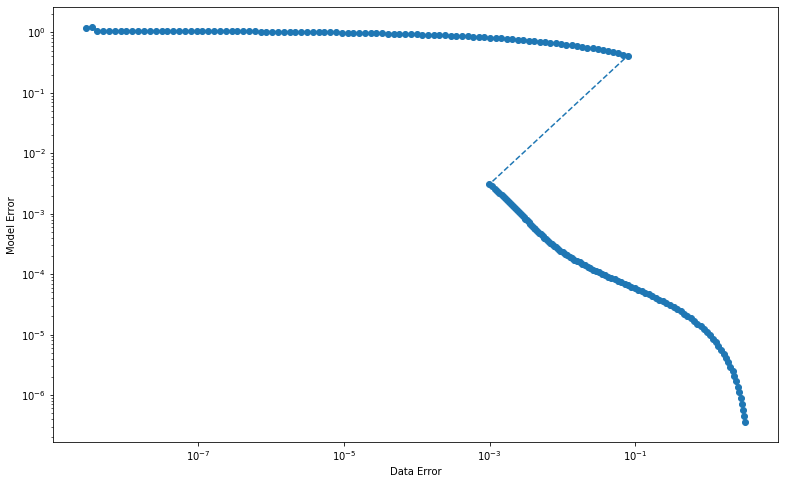

In [13]:
idx = 115
plt.loglog(*fsvals.T, 'o--')
# plt.loglog(*fsvals[idx], 'ro')
plt.xlabel("Data Error")
plt.ylabel("Model Error")

Text(0, 0.5, 'Value of $p_1$')

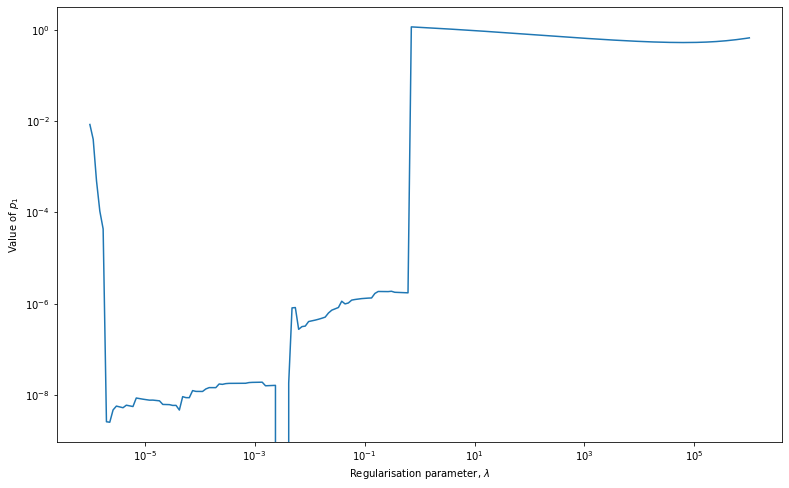

In [14]:
plt.loglog(prange, [s['x'][-2] for s in solutions])
# idx= 115
# plt.loglog(prange[idx], solutions[idx]['x'][-2], 'ro')
plt.xlabel(r"Regularisation parameter, $\lambda$")
plt.ylabel(r"Value of $p_1$")

Text(0, 0.5, 'Value of $p_2$')

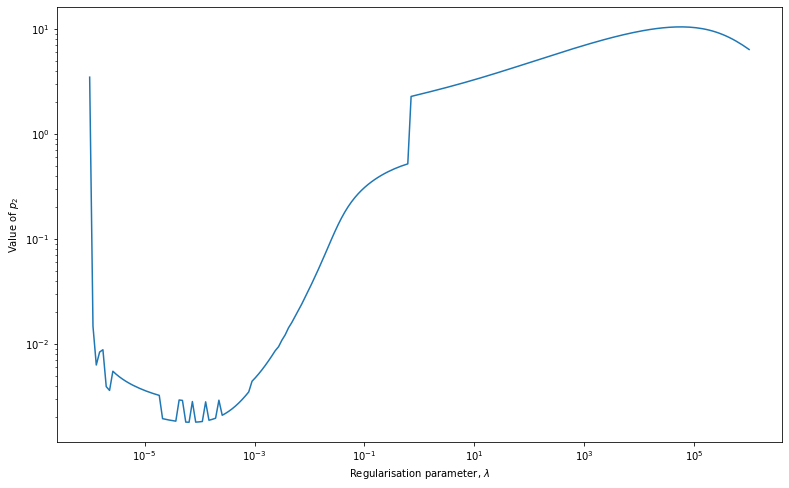

In [15]:
plt.loglog(prange, [s['x'][-1] for s in solutions])
# idx= 115
# plt.loglog(prange[idx], solutions[idx]['x'][-1], 'ro')
plt.xlabel(r"Regularisation parameter, $\lambda$")
plt.ylabel(r"Value of $p_2$")

errors 0.00324813 0.000772869
p: (DM(0.976147), DM(3.21381))


Text(0, 0.5, '$x_1$')

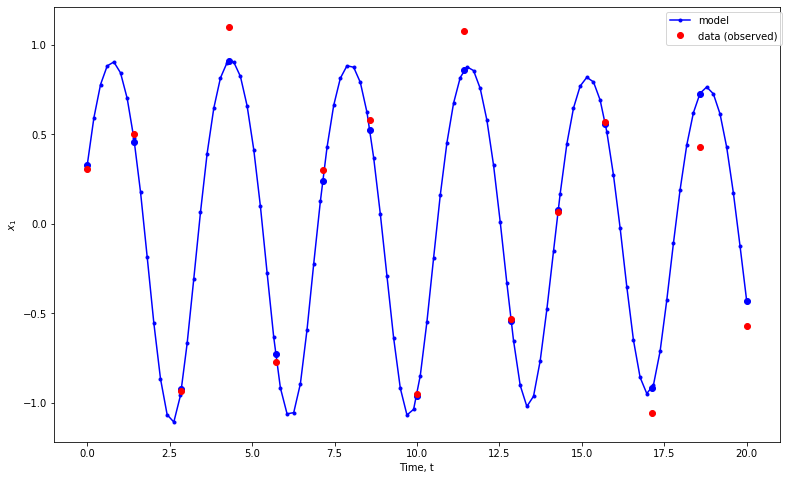

In [18]:
idx = 115
print("errors", f1_ex(solutions[idx]['x']), f2_ex(solutions[idx]['x']))
print("p:", getp(solutions[idx]['x']))
plt.plot(model.observation_times, getx(solutions[idx]['x'])[0], 'b-', label='model')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])[0]).flatten()).T, 'bo')#, label='model (collocation)')
plt.plot(neat_ts, data.T, 'ro', label='data (observed)')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("Time, t")
plt.ylabel("$x_1$")

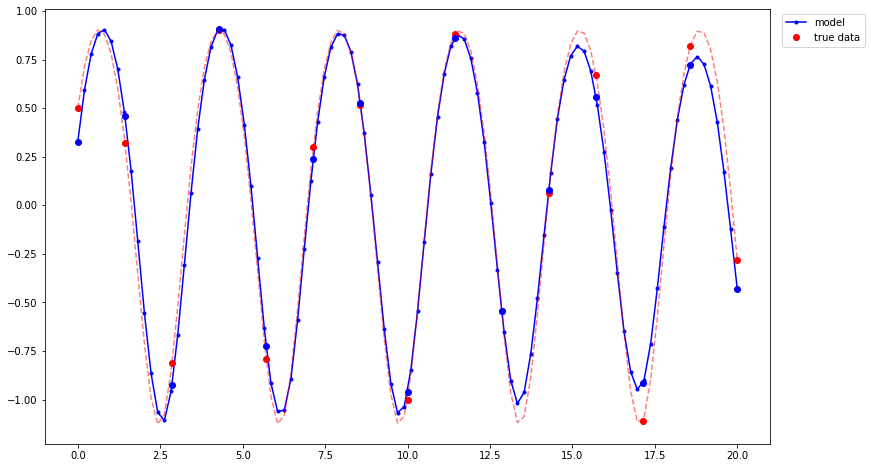

In [19]:
idx = 115
plt.plot(model.observation_times, getx(solutions[idx]['x'])[0], 'b-', label='model')
plt.plot(model.observation_times, sol.sol(model.observation_times)[0], 'r--', alpha=0.5)
plt.plot(neat_ts, sol.sol(neat_ts)[0].T, 'ro', label='true data')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])[0]).flatten()).T, 'bo')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))

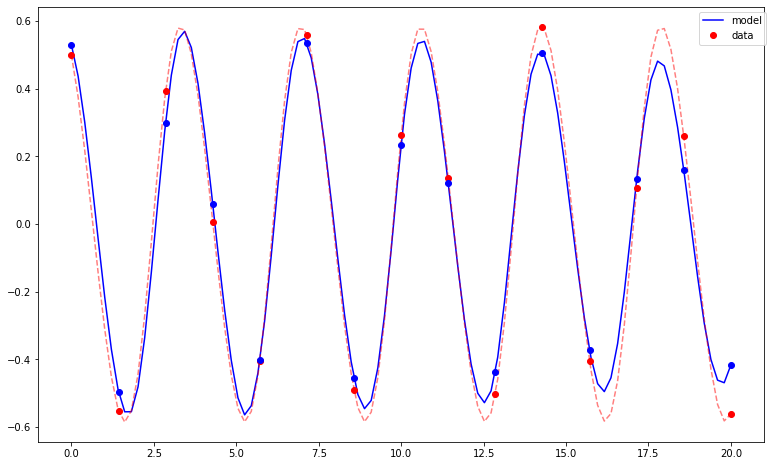

In [20]:
idx = 115
plt.plot(model.observation_times, getx(solutions[idx]['x'])[1], 'b-', label='model')
plt.plot(model.observation_times, sol.sol(model.observation_times)[1], 'r--', alpha=0.5)
plt.plot(neat_ts, sol.sol(neat_ts)[1].T, 'ro', label='data')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])[1]).flatten()).T, 'bo')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))

Text(0, 0.5, '$|| y-c\\Phi ||$')

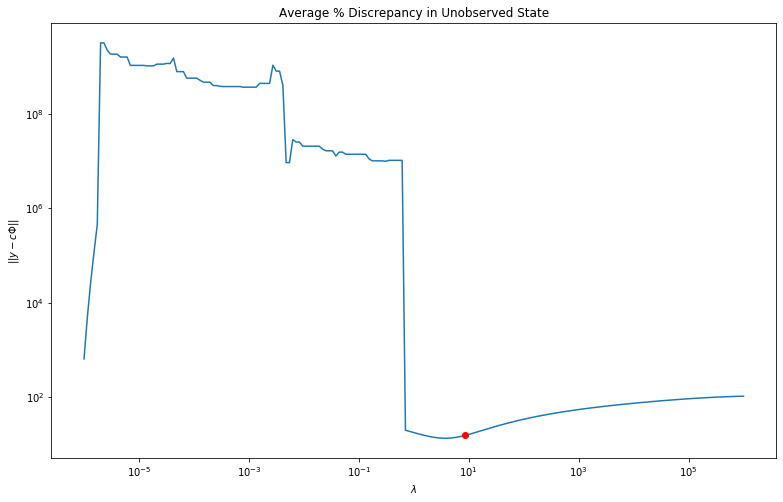

In [21]:
cvfn = lambda idx : np.sqrt(np.sum(((np.array(getx(solutions[idx]['x'])[1]).flatten()) - sol.sol(model.observation_times)[1])**2)/len(model.observation_times))
validation = [100*cvfn(i)/np.mean(np.abs(sol.sol(model.observation_times)[1])) for i in range(200)]
idx = 115
plt.loglog(prange, validation)
plt.loglog(prange[idx], validation[idx], 'ro')
plt.title("Average % Discrepancy in Unobserved State")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$|| y-c\Phi ||$")

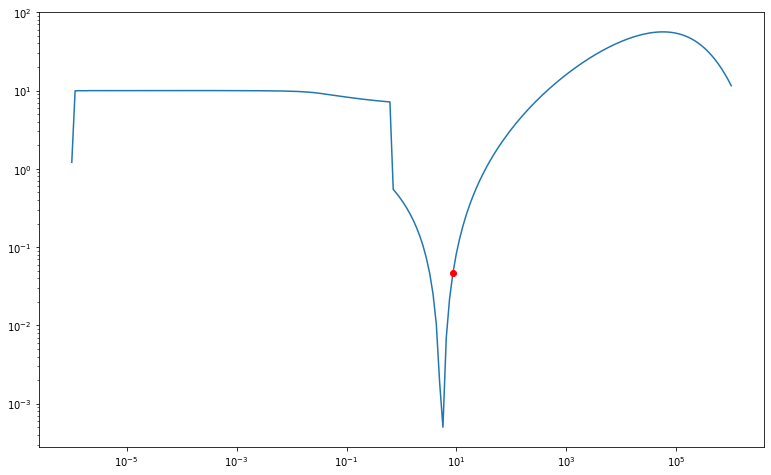

In [22]:
pwrongness = lambda idx: np.sum((np.array(p_true) - np.array(getp(solutions[idx]['x'])))**2)
perr = [pwrongness(i) for i in range(200)]
plt.loglog(prange, perr)
idx = 115
plt.loglog(prange[idx], perr[idx], 'ro')

In [23]:
# backprop

idx0 = 199

prangebp = np.logspace(np.log10(prange[idx0]), -6, num=idx0+1)
solutionsbp = []
xguess = np.array(solutions[idx0]['x']).flatten()
for p in prangebp:
#     solutionsbp.append(solver(x0=xguess, p=[p, p**(2/7)/(10**(26/7))], lbx=lbx))
    solutionsbp.append(solver(x0=xguess, p=[p, (np.log10(p)+6)*1e-4], lbx=lbx))
    xguess = np.array(solutionsbp[-1]['x']).flatten()


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3403

Total number of variables............................:       82
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  13  3.4584906e+00 0.00e+00 1.86e-07  -8.6 2.62e-05    -  1.00e+00 1.00e+00f  1
  14  3.4584906e+00 0.00e+00 9.32e-12  -8.6 4.21e-11    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   3.4584905598344502e+00    3.4584905598344502e+00
Dual infeasibility......:   9.3169916226543137e-12    9.3169916226543137e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800994e-09    2.5059035596800994e-09
Overall NLP error.......:   2.5059035596800994e-09    2.5059035596800994e-09


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numbe

   7  3.2327577e+00 0.00e+00 5.62e-01  -2.5 4.26e-02    -  1.00e+00 1.00e+00f  1
   8  3.2327555e+00 0.00e+00 1.53e-02  -2.5 7.20e-03    -  1.00e+00 1.00e+00f  1
   9  3.2327541e+00 0.00e+00 1.56e-01  -3.8 2.33e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2327539e+00 0.00e+00 1.35e-04  -3.8 6.28e-04    -  1.00e+00 1.00e+00f  1
  11  3.2327539e+00 0.00e+00 1.31e-03  -5.7 2.10e-03    -  1.00e+00 1.00e+00f  1
  12  3.2327539e+00 0.00e+00 3.42e-10  -5.7 8.13e-07    -  1.00e+00 1.00e+00f  1
  13  3.2327539e+00 0.00e+00 1.58e-07  -8.6 2.31e-05    -  1.00e+00 1.00e+00f  1
  14  3.2327539e+00 0.00e+00 9.83e-12  -8.6 2.81e-11    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   3.2327538885209131e+00    3.2327538885209131e+00
Dual infeasibility......:   9.8259178571424854e-12    9.8259178571424854e-12
Constraint viol

   3  2.9574465e+00 0.00e+00 2.44e+00  -2.5 1.84e-01    -  1.00e+00 5.00e-01f  2
   4  2.9573830e+00 0.00e+00 1.44e-01  -2.5 2.62e-02    -  1.00e+00 1.00e+00f  1
   5  2.9573751e+00 0.00e+00 6.07e-01  -2.5 8.12e-02    -  1.00e+00 5.00e-01f  2
   6  2.9573707e+00 0.00e+00 2.64e-01  -2.5 2.88e-02    -  1.00e+00 1.00e+00f  1
   7  2.9573713e+00 0.00e+00 1.51e-01  -2.5 2.17e-02    -  1.00e+00 1.00e+00f  1
   8  2.9573722e+00 0.00e+00 2.23e-02  -2.5 8.37e-03    -  1.00e+00 1.00e+00f  1
   9  2.9573704e+00 0.00e+00 2.18e-01  -3.8 2.67e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9573701e+00 0.00e+00 2.21e-04  -3.8 7.90e-04    -  1.00e+00 1.00e+00f  1
  11  2.9573701e+00 0.00e+00 1.25e-03  -5.7 2.00e-03    -  1.00e+00 1.00e+00f  1
  12  2.9573701e+00 0.00e+00 4.02e-10  -5.7 9.06e-07    -  1.00e+00 1.00e+00f  1
  13  2.9573701e+00 0.00e+00 1.33e-07  -8.6 2.08e-05    -  1.00e+00 1.00e+00f  1
  14  2.9573701e+00 0.00e+00

   5  2.6431103e+00 0.00e+00 6.14e-01  -2.5 4.36e-02    -  1.00e+00 1.00e+00f  1
   6  2.6431087e+00 0.00e+00 1.88e-02  -2.5 7.81e-03    -  1.00e+00 1.00e+00f  1
   7  2.6431076e+00 0.00e+00 1.18e-01  -3.8 1.97e-02    -  1.00e+00 1.00e+00f  1
   8  2.6431075e+00 0.00e+00 8.60e-05  -3.8 4.96e-04    -  1.00e+00 1.00e+00f  1
   9  2.6431075e+00 0.00e+00 8.25e-04  -5.7 1.63e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6431075e+00 0.00e+00 7.69e-11  -5.7 2.93e-07    -  1.00e+00 1.00e+00f  1
  11  2.6431075e+00 0.00e+00 1.13e-07  -8.6 1.90e-05    -  1.00e+00 1.00e+00f  1
  12  2.6431075e+00 0.00e+00 6.56e-12  -8.6 1.32e-11    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   2.6431075125174353e+00    2.6431075125174353e+00
Dual infeasibility......:   6.5554228712016993e-12    6.5554228712016993e-12
Constraint viol

   9  2.3070521e+00 0.00e+00 9.50e-08  -8.6 1.77e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3070521e+00 0.00e+00 7.66e-12  -8.6 9.18e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   2.3070520893954320e+00    2.3070520893954320e+00
Dual infeasibility......:   7.6634148333834548e-12    7.6634148333834548e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800647e-09    2.5059035596800647e-09
Overall NLP error.......:   2.5059035596800647e-09    2.5059035596800647e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian

   2  1.8585593e+00 0.00e+00 9.59e-03  -1.0 4.91e-03   0.0 1.00e+00 1.00e+00f  1
   3  1.8585407e+00 0.00e+00 3.69e-02  -2.5 1.04e-02    -  1.00e+00 1.00e+00f  1
   4  1.8585409e+00 0.00e+00 2.61e-04  -2.5 9.55e-04    -  1.00e+00 1.00e+00f  1
   5  1.8585393e+00 0.00e+00 1.58e-01  -3.8 2.40e-02    -  1.00e+00 1.00e+00f  1
   6  1.8585391e+00 0.00e+00 6.16e-08  -3.8 1.42e-05    -  1.00e+00 1.00e+00f  1
   7  1.8585391e+00 0.00e+00 4.95e-04  -5.7 1.34e-03    -  1.00e+00 1.00e+00f  1
   8  1.8585391e+00 0.00e+00 1.78e-11  -5.7 3.61e-08    -  1.00e+00 1.00e+00f  1
   9  1.8585391e+00 0.00e+00 7.55e-08  -8.6 1.66e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8585391e+00 0.00e+00 5.71e-12  -8.6 5.62e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.8585391330250711e+00    1.8585391330250711e+00
Dual infeas

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3403

Total number of variables............................:       82
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4504249e+00 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

   5  1.0932130e+00 0.00e+00 1.50e-01  -3.8 2.78e-02    -  1.00e+00 1.00e+00f  1
   6  1.0932128e+00 0.00e+00 1.20e-07  -3.8 2.16e-05    -  1.00e+00 1.00e+00f  1
   7  1.0932128e+00 0.00e+00 3.18e-04  -5.7 1.28e-03    -  1.00e+00 1.00e+00f  1
   8  1.0932128e+00 0.00e+00 2.12e-11  -5.7 7.85e-09    -  1.00e+00 1.00e+00f  1
   9  1.0932128e+00 0.00e+00 4.84e-08  -8.6 1.57e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0932128e+00 0.00e+00 3.04e-12  -8.6 1.38e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0932127742273017e+00    1.0932127742273017e+00
Dual infeasibility......:   3.0372233394348855e-12    3.0372233394348855e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800630e-09    2.5059035596800630e-09
Overall NLP error......

  19  8.7406058e-01 0.00e+00 2.60e-11  -5.7 1.67e-07    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  8.7406058e-01 0.00e+00 4.13e-08  -8.6 1.59e-05    -  1.00e+00 1.00e+00f  1
  21  8.7406058e-01 0.00e+00 6.05e-13  -8.6 5.34e-13    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   8.7406057933965975e-01    8.7406057933965975e-01
Dual infeasibility......:   6.0548788205494475e-13    6.0548788205494475e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800630e-09    2.5059035596800630e-09
Overall NLP error.......:   2.5059035596800630e-09    2.5059035596800630e-09


Number of objective function evaluations             = 45
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 0
Number of ineq

   1  6.9287220e-01 0.00e+00 1.21e+00  -1.0 3.93e-02    -  9.96e-01 1.00e+00f  1
   2  6.9328280e-01 0.00e+00 3.54e+00  -1.0 7.11e-01  -2.0 1.00e+00 2.50e-01f  3
   3  6.9337251e-01 0.00e+00 1.02e+00  -1.0 1.08e-01    -  1.00e+00 1.00e+00f  1
   4  6.9416696e-01 0.00e+00 4.40e+00  -1.0 1.80e-01    -  1.00e+00 1.00e+00f  1
   5  6.9403968e-01 0.00e+00 1.60e-01  -1.0 3.76e-02    -  1.00e+00 1.00e+00f  1
   6  6.9365094e-01 0.00e+00 2.12e+00  -2.5 5.27e-01    -  1.00e+00 2.50e-01f  3
   7  6.9327702e-01 0.00e+00 2.29e+00  -2.5 1.43e-01    -  1.00e+00 1.00e+00f  1
   8  6.9303107e-01 0.00e+00 1.17e+00  -2.5 9.16e-02    -  1.00e+00 1.00e+00f  1
   9  6.9288903e-01 0.00e+00 1.60e+00  -2.5 1.09e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.9279958e-01 0.00e+00 3.93e-01  -2.5 5.29e-02    -  1.00e+00 1.00e+00f  1
  11  6.9275960e-01 0.00e+00 8.07e-01  -2.5 7.65e-02    -  1.00e+00 1.00e+00f  1
  12  6.9274333e-01 0.00e+00

  10  5.9120745e-01 0.00e+00 3.24e-08  -8.6 1.65e-05    -  1.00e+00 1.00e+00f  1
  11  5.9120745e-01 0.00e+00 1.50e-12  -8.6 1.99e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   5.9120745082025394e-01    5.9120745082025394e-01
Dual infeasibility......:   1.5015134939376508e-12    1.5015134939376508e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800638e-09    2.5059035596800638e-09
Overall NLP error.......:   2.5059035596800638e-09    2.5059035596800638e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numbe

   2  4.2859071e-01 0.00e+00 5.74e-03  -1.7 4.57e-03    -  1.00e+00 1.00e+00f  1
   3  4.2852528e-01 0.00e+00 7.69e-01  -3.8 1.90e-01    -  9.97e-01 5.00e-01f  2
   4  4.2848899e-01 0.00e+00 1.52e-01  -3.8 4.18e-02    -  1.00e+00 1.00e+00f  1
   5  4.2848014e-01 0.00e+00 1.70e-01  -3.8 4.30e-02    -  1.00e+00 1.00e+00f  1
   6  4.2847885e-01 0.00e+00 6.85e-03  -3.8 8.51e-03    -  1.00e+00 1.00e+00f  1
   7  4.2847880e-01 0.00e+00 5.92e-04  -3.8 2.53e-03    -  1.00e+00 1.00e+00f  1
   8  4.2847880e-01 0.00e+00 1.83e-04  -5.7 1.43e-03    -  1.00e+00 1.00e+00f  1
   9  4.2847880e-01 0.00e+00 2.39e-10  -5.7 1.44e-06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2847880e-01 0.00e+00 2.71e-08  -8.6 1.74e-05    -  1.00e+00 1.00e+00f  1
  11  4.2847880e-01 0.00e+00 8.83e-13  -8.6 4.06e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objecti

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1054070e-01 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.1000268e-01 0.00e+00 2.67e-01  -1.0 3.94e-02    -  9.97e-01 1.00e+00f  1
   2  3.0999138e-01 0.00e+00 2.41e-02  -1.7 1.90e-02    -  1.00e+00 1.00e+00f  1
   3  3.0991146e-01 0.00e+00 6.72e-01  -3.8 2.05e-01    -  9.95e-01 5.00e-01f  2
   4  3.0986540e-01 0.00e+00 1.43e-01  -3.8 4.70e-02    -  1.00e+00 1.00e+00f  1
   5  3.0985340e-01 0.00e+00 1.65e-01  -3.8 4.92e-02    -  1.00e+00 1.00e+00f  1
   6  3.0985141e-01 0.00e+00 7.75e-03  -3.8 1.05e-02    -  1.00e+00 1.00e+00f  1
   7  3.0985133e-01 0.00e+00 8.89e-04  -3.8 3.60e-03    -  1.00e+00 1.00e+00f  1
   8  3.0985133e-01 0.00e+00 1.60e-04  -5.7 1.55e-03    -  1.00e+00 1.00e+00f  1
   9  3.0985133e-01 0.00e+00 6.15e-10  -5.7 2.80e-06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0985133e-01 0.00e+00

   7  2.4327654e-01 0.00e+00 1.81e-11  -5.7 5.28e-08    -  1.00e+00 1.00e+00f  1
   8  2.4327654e-01 0.00e+00 2.03e-08  -8.6 1.96e-05    -  1.00e+00 1.00e+00f  1
   9  2.4327654e-01 0.00e+00 1.23e-13  -9.0 1.70e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.4327653895567791e-01    2.4327653895567791e-01
Dual infeasibility......:   1.2347502770027997e-13    1.2347502770027997e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091269090769e-10    9.0909091269090769e-10
Overall NLP error.......:   9.0909091269090769e-10    9.0909091269090769e-10


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian 

Objective...............:   1.7699313009588583e-01    1.7699313009588583e-01
Dual infeasibility......:   1.9378821958131420e-13    1.9378821958131420e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091335286539e-10    9.0909091335286539e-10
Overall NLP error.......:   9.0909091335286539e-10    9.0909091335286539e-10


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.007
Total CPU secs in NLP function evaluations           =      0.047

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval

   5  1.2973542e-01 0.00e+00 3.52e-02  -3.8 3.61e-02    -  1.00e+00 1.00e+00f  1
   6  1.2973514e-01 0.00e+00 4.88e-05  -3.8 1.22e-03    -  1.00e+00 1.00e+00f  1
   7  1.2973513e-01 0.00e+00 1.15e-04  -5.7 2.05e-03    -  1.00e+00 1.00e+00f  1
   8  1.2973513e-01 0.00e+00 1.80e-11  -5.7 1.27e-07    -  1.00e+00 1.00e+00f  1
   9  1.2973513e-01 0.00e+00 1.49e-08  -8.6 2.34e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2973513e-01 0.00e+00 2.78e-14  -9.0 2.02e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.2973513081779844e-01    1.2973513081779844e-01
Dual infeasibility......:   2.7811086766860171e-14    2.7811086766860171e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091418861745e-10    9.0909091418861745e-10
Overall NLP error......

   6  9.5983968e-02 0.00e+00 8.29e-05  -5.7 2.07e-03    -  1.00e+00 1.00e+00f  1
   7  9.5983968e-02 0.00e+00 1.79e-11  -5.7 2.45e-07    -  1.00e+00 1.00e+00f  1
   8  9.5983968e-02 0.00e+00 1.27e-08  -8.6 2.57e-05    -  1.00e+00 1.00e+00f  1
   9  9.5983968e-02 0.00e+00 1.12e-13  -9.0 2.22e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   9.5983968281777410e-02    9.5983968281777410e-02
Dual infeasibility......:   1.1209384892507110e-13    1.1209384892507110e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091522916176e-10    9.0909091522916176e-10
Overall NLP error.......:   9.0909091522916176e-10    9.0909091522916176e-10


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequ

   8  7.1758343e-02 0.00e+00 1.09e-08  -8.6 2.83e-05    -  1.00e+00 1.00e+00f  1
   9  7.1758343e-02 0.00e+00 1.67e-14  -9.0 2.44e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   7.1758342577444997e-02    7.1758342577444997e-02
Dual infeasibility......:   1.6659200061108770e-14    1.6659200061108770e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091650894179e-10    9.0909091650894179e-10
Overall NLP error.......:   9.0909091650894179e-10    9.0909091650894179e-10


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number

   0  5.0762245e-02 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.0837227e-02 0.00e+00 4.14e-03  -1.0 4.43e-02    -  1.00e+00 1.00e+00f  1
   2  5.0689993e-02 0.00e+00 9.13e-02  -2.5 1.05e-01    -  1.00e+00 1.00e+00f  1
   3  5.0675392e-02 0.00e+00 8.15e-06  -2.5 4.48e-04    -  1.00e+00 1.00e+00f  1
   4  5.0668300e-02 0.00e+00 1.94e-02  -3.8 4.77e-02    -  1.00e+00 1.00e+00f  1
   5  5.0667777e-02 0.00e+00 1.13e-06  -3.8 2.04e-04    -  1.00e+00 1.00e+00f  1
   6  5.0667756e-02 0.00e+00 5.67e-05  -5.7 2.56e-03    -  1.00e+00 1.00e+00f  1
   7  5.0667756e-02 0.00e+00 1.77e-11  -5.7 6.36e-07    -  1.00e+00 1.00e+00f  1
   8  5.0667756e-02 0.00e+00 8.82e-09  -8.6 3.19e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   5.0667756218669452e-02    5.0667756218669452e-02
Dual infeasibility......:   8.8214150648785878e-09    8.8214150648785878e-09
Constraint viola

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3403

Total number of variables............................:       82
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.6483468e-02 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

   2  2.6660913e-02 0.00e+00 1.40e-02  -2.5 6.72e-02    -  1.00e+00 1.00e+00f  1
   3  2.6647477e-02 0.00e+00 8.29e-03  -3.8 4.98e-02    -  1.00e+00 1.00e+00f  1
   4  2.6646530e-02 0.00e+00 3.20e-04  -3.8 9.27e-03    -  1.00e+00 1.00e+00f  1
   5  2.6646470e-02 0.00e+00 6.57e-05  -5.7 4.37e-03    -  1.00e+00 1.00e+00f  1
   6  2.6646470e-02 0.00e+00 1.24e-09  -5.7 1.64e-05    -  1.00e+00 1.00e+00f  1
   7  2.6646470e-02 0.00e+00 5.57e-09  -8.6 4.05e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.6646470270429715e-02    2.6646470270429715e-02
Dual infeasibility......:   5.5713634307094615e-09    5.5713634307094615e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5258472217855437e-09    2.5258472217855437e-09
Overall NLP error.......:   5.5713634307094615e-09    5.5713634307094615e-09


Number of objective functi

   1  1.9099704e-02 0.00e+00 1.68e-03  -1.0 4.69e-02    -  1.00e+00 1.00e+00f  1
   2  1.8761644e-02 0.00e+00 4.15e-03  -2.5 4.83e-02    -  1.00e+00 1.00e+00f  1
   3  1.8747238e-02 0.00e+00 6.57e-03  -3.8 6.05e-02    -  1.00e+00 1.00e+00f  1
   4  1.8746385e-02 0.00e+00 4.41e-05  -3.8 4.30e-03    -  1.00e+00 1.00e+00f  1
   5  1.8746326e-02 0.00e+00 3.66e-05  -5.7 4.40e-03    -  1.00e+00 1.00e+00f  1
   6  1.8746326e-02 0.00e+00 9.60e-12  -5.7 7.60e-07    -  1.00e+00 1.00e+00f  1
   7  1.8746326e-02 0.00e+00 4.11e-09  -8.6 4.67e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.8746326056414634e-02    1.8746326056414634e-02
Dual infeasibility......:   4.1112763328995372e-09    4.1112763328995372e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5321436666884229e-09    2.5321436666884229e-09
Overall NLP error.......

   0  1.3520203e-02 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.4055982e-02 0.00e+00 1.27e-03  -1.0 5.06e-02    -  1.00e+00 1.00e+00f  1
   2  1.3514511e-02 0.00e+00 1.79e-03  -2.5 4.52e-02    -  1.00e+00 1.00e+00f  1
   3  1.3497954e-02 0.00e+00 4.16e-03  -3.8 6.67e-02    -  1.00e+00 1.00e+00f  1
   4  1.3497214e-02 0.00e+00 6.49e-06  -3.8 1.99e-03    -  1.00e+00 1.00e+00f  1
   5  1.3497149e-02 0.00e+00 2.22e-05  -5.7 4.68e-03    -  1.00e+00 1.00e+00f  1
   6  1.3497149e-02 0.00e+00 1.97e-11  -5.7 5.08e-06    -  1.00e+00 1.00e+00f  1
   7  1.3497149e-02 0.00e+00 2.99e-09  -8.6 5.42e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.3497148863188320e-02    1.3497148863188320e-02
Dual infeasibility......:   2.9916334697221706e-09    2.9916334697221706e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   4  9.8950228e-03 0.00e+00 3.65e-06  -3.8 2.08e-03    -  1.00e+00 1.00e+00f  1
   5  9.8949404e-03 0.00e+00 1.53e-05  -5.7 5.34e-03    -  1.00e+00 1.00e+00f  1
   6  9.8949404e-03 0.00e+00 1.99e-09  -8.6 5.54e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   9.8949403505570917e-03    9.8949403505570917e-03
Dual infeasibility......:   1.9881692005417292e-09    1.9881692005417292e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5518706616511574e-09    2.5518706616511574e-09
Overall NLP error.......:   2.5518706616511574e-09    2.5518706616511574e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

Objective...............:   7.3419472980531279e-03    7.3419472980531279e-03
Dual infeasibility......:   1.5724197947747404e-09    1.5724197947747404e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5657321235749749e-09    2.5657321235749749e-09
Overall NLP error.......:   2.5657321235749749e-09    2.5657321235749749e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
Total CPU secs in NLP function evaluations           =      0.028

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
  

Dual infeasibility......:   1.1226966577069340e-09    1.1226966577069340e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5849071937292288e-09    2.5849071937292288e-09
Overall NLP error.......:   2.5849071937292288e-09    2.5849071937292288e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
Total CPU secs in NLP function evaluations           =      0.027

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f     0.000225     0.000223         7
    nlp_grad     0.000284     

   5  4.1665302e-03 0.00e+00 3.47e-08  -5.7 5.96e-04    -  1.00e+00 1.00e+00f  1
   6  4.1665302e-03 0.00e+00 8.20e-10  -8.6 1.09e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   4.1665301791636734e-03    4.1665301791636734e-03
Dual infeasibility......:   8.1951841139683698e-10    8.1951841139683698e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6123092533240814e-09    2.6123092533240814e-09
Overall NLP error.......:   2.6123092533240814e-09    2.6123092533240814e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

   3  3.0840419e-03 0.00e+00 9.65e-05  -3.8 1.68e-01    -  1.00e+00 1.00e+00f  1
   4  3.0836466e-03 0.00e+00 1.15e-06  -5.7 8.10e-03    -  1.00e+00 1.00e+00f  1
   5  3.0836465e-03 0.00e+00 1.31e-09  -8.6 1.90e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   3.0836465047473479e-03    3.0836465047473479e-03
Dual infeasibility......:   1.3055047825912623e-09    1.3055047825912623e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7704913581647165e-09    2.7704913581647165e-09
Overall NLP error.......:   2.7704913581647165e-09    2.7704913581647165e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   1  2.8091473e-03 0.00e+00 6.67e-03  -1.0 1.23e-01    -  9.93e-01 1.00e+00f  1
   2  2.3776343e-03 0.00e+00 5.39e-04  -3.8 2.43e-01    -  1.00e+00 1.00e+00f  1
   3  2.3539712e-03 0.00e+00 3.44e-05  -5.7 1.66e-01    -  9.97e-01 1.00e+00f  1
   4  2.3537788e-03 0.00e+00 4.53e-07  -5.7 8.87e-03    -  1.00e+00 1.00e+00f  1
   5  2.3537787e-03 0.00e+00 4.21e-10  -8.6 1.74e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.3537787414198625e-03    2.3537787414198625e-03
Dual infeasibility......:   4.2122155054138102e-10    4.2122155054138102e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6815427307509913e-09    2.6815427307509913e-09
Overall NLP error.......:   2.6815427307509913e-09    2.6815427307509913e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

   0  1.8480646e-03 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.0679108e-03 0.00e+00 8.31e-03  -1.0 2.11e-01    -  9.92e-01 1.00e+00f  1
   2  1.8680451e-03 0.00e+00 5.20e-05  -3.8 1.41e-01    -  1.00e+00 1.00e+00f  1
   3  1.8468263e-03 0.00e+00 4.26e-05  -5.7 1.30e-01    -  1.00e+00 1.00e+00f  1
   4  1.8466836e-03 0.00e+00 2.40e-07  -5.7 1.16e-02    -  1.00e+00 1.00e+00f  1
   5  1.8466835e-03 0.00e+00 3.58e-10  -8.6 2.82e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.8466834547755276e-03    1.8466834547755276e-03
Dual infeasibility......:   3.5812596398666322e-10    3.5812596398666322e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8905111006983234e-09    2.8905111006983234e-09
Overall NLP error.......:   2.8905111006983234e-09    2.8905111006983234e-09


Number of objective functi

   1  1.5625991e-03 0.00e+00 9.18e-03  -1.0 3.24e-01    -  9.91e-01 1.00e+00f  1
   2  1.4879189e-03 0.00e+00 3.23e-05  -3.8 1.30e-01    -  1.00e+00 1.00e+00f  1
   3  1.4588780e-03 0.00e+00 3.84e-05  -5.7 1.79e-01    -  1.00e+00 1.00e+00f  1
   4  1.4582603e-03 0.00e+00 2.34e-06  -5.7 8.10e-02    -  1.00e+00 1.00e+00f  1
   5  1.4582584e-03 0.00e+00 5.06e-09  -8.6 1.91e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.4582583527825417e-03    1.4582583527825417e-03
Dual infeasibility......:   5.0617357751318814e-09    5.0617357751318814e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.5299024930485896e-09    3.5299024930485896e-09
Overall NLP error.......:   5.0617357751318814e-09    5.0617357751318814e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

   4  1.1471745e-03 0.00e+00 7.60e-06  -5.7 1.65e-01    -  1.00e+00 1.00e+00f  1
   5  1.1471288e-03 0.00e+00 1.36e-07  -8.6 1.03e-02    -  1.00e+00 1.00e+00f  1
   6  1.1471288e-03 0.00e+00 5.48e-11  -8.6 4.32e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   1.1471287558376035e-03    1.1471287558376035e-03
Dual infeasibility......:   5.4826800837509327e-11    5.4826800837509327e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5065041194929107e-09    2.5065041194929107e-09
Overall NLP error.......:   2.5065041194929107e-09    2.5065041194929107e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   6  6.8868977e-04 0.00e+00 1.38e-06  -8.6 2.32e-02  -5.4 1.00e+00 1.00e+00f  1
   7  6.8753577e-04 0.00e+00 1.15e-07  -8.6 1.26e-02  -5.9 1.00e+00 1.00e+00f  1
   8  6.8721431e-04 0.00e+00 1.38e-08  -8.6 6.10e-03  -6.4 1.00e+00 1.00e+00f  1
   9  6.8712345e-04 0.00e+00 5.64e-09  -8.6 2.95e-03  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.8710170e-04 0.00e+00 1.15e-09  -9.0 1.65e-03  -7.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   6.8710169795353293e-04    6.8710169795353293e-04
Dual infeasibility......:   1.1541497123653986e-09    1.1541497123653986e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6437416175028770e-09    2.6437416175028770e-09
Overall NLP error.......:   2.6437416175028770e-09    2.6437416175028770e-09


Number of objective funct

   5  5.5790148e-03 0.00e+00 4.77e-03  -2.5 4.61e-02  -1.4 1.00e+00 1.00e+00f  1
   6  3.2909539e-03 0.00e+00 1.21e-02  -3.8 4.40e-02  -1.9 1.00e+00 1.00e+00f  1
   7  2.5616716e-03 0.00e+00 2.49e-02  -3.8 1.12e-01  -2.3 1.00e+00 1.00e+00f  1
   8  2.1397639e-03 0.00e+00 2.26e-02  -3.8 2.32e-01  -2.8 1.00e+00 1.00e+00f  1
   9  1.7149162e-03 0.00e+00 1.00e-02  -3.8 2.52e-01  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2108823e-03 0.00e+00 1.50e-03  -3.8 4.70e-01  -3.8 1.00e+00 1.00e+00f  1
  11  6.6759135e-04 0.00e+00 8.64e-03  -5.7 7.38e-01  -4.3 1.00e+00 1.00e+00f  1
  12  4.8080210e-04 0.00e+00 1.90e-03  -5.7 5.94e-01  -4.7 1.00e+00 1.00e+00f  1
  13  4.6119623e-04 0.00e+00 3.73e-05  -5.7 2.08e-01  -5.2 1.00e+00 1.00e+00f  1
  14  4.5944676e-04 0.00e+00 1.47e-05  -5.7 2.66e-02  -5.7 1.00e+00 1.00e+00f  1
  15  4.5778652e-04 0.00e+00 4.21e-05  -8.6 2.92e-02  -6.2 1.00e+00 1.00e+00f  1
  16  4.5733540e-04 0.00e+00

  11  2.6729707e-04 0.00e+00 3.37e-05  -5.7 6.66e-02  -8.8 1.00e+00 1.00e+00f  1
  12  2.6709212e-04 0.00e+00 8.42e-07  -5.7 2.06e-01  -9.2 1.00e+00 1.00e+00f  1
  13  2.6561971e-04 0.00e+00 3.07e-05  -8.6 2.93e-02  -9.7 1.00e+00 1.00e+00f  1
  14  2.6522220e-04 0.00e+00 2.58e-06  -8.6 1.49e-02 -10.2 1.00e+00 1.00e+00f  1
  15  2.6511488e-04 0.00e+00 5.72e-08  -8.6 7.36e-03 -10.7 1.00e+00 1.00e+00f  1
  16  2.6508706e-04 0.00e+00 3.77e-08  -8.6 2.25e-02 -11.2 1.00e+00 1.00e+00f  1
  17  2.6508185e-04 0.00e+00 9.55e-09  -8.6 6.76e-02 -11.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   2.6508185443214772e-04    2.6508185443214772e-04
Dual infeasibility......:   9.5475152332713531e-09    9.5475152332713531e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.6635137210346974e-09    3.6635137210346974e-09
Overall NLP error......

   8  1.9957117e-04 0.00e+00 1.05e-02  -5.7 2.45e-01  -7.3 1.00e+00 1.00e+00f  1
   9  1.6682417e-04 0.00e+00 6.21e-03  -5.7 1.37e-01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5749710e-04 0.00e+00 1.09e-03  -5.7 7.11e-02  -8.3 1.00e+00 1.00e+00f  1
  11  1.5563193e-04 0.00e+00 6.90e-05  -5.7 3.30e-02  -8.8 1.00e+00 1.00e+00f  1
  12  1.5540473e-04 0.00e+00 1.20e-06  -5.7 1.03e-01  -9.2 1.00e+00 1.00e+00f  1
  13  1.5395607e-04 0.00e+00 5.19e-05  -8.6 3.11e-02  -9.7 1.00e+00 1.00e+00f  1
  14  1.5356831e-04 0.00e+00 4.96e-06  -8.6 1.59e-02 -10.2 1.00e+00 1.00e+00f  1
  15  1.5346475e-04 0.00e+00 3.94e-08  -8.6 7.81e-03 -10.7 1.00e+00 1.00e+00f  1
  16  1.5343700e-04 0.00e+00 1.05e-07  -8.6 1.13e-02 -11.2 1.00e+00 1.00e+00f  1
  17  1.5343100e-04 0.00e+00 7.17e-09  -8.6 3.38e-02 -11.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objecti

  12  2.9717596e-04 0.00e+00 1.41e-02  -3.8 3.14e-01  -4.5 1.00e+00 1.00e+00f  1
  13  2.4191671e-04 0.00e+00 5.56e-03  -3.8 3.83e-01  -5.0 1.00e+00 1.00e+00f  1
  14  2.2689161e-04 0.00e+00 2.15e-03  -3.8 2.38e-01  -5.5 1.00e+00 1.00e+00f  1
  15  2.2431350e-04 0.00e+00 1.03e-04  -3.8 6.22e-02  -6.0 1.00e+00 1.00e+00f  1
  16  1.4219235e-04 0.00e+00 1.83e-02  -5.7 3.37e-01  -6.4 1.00e+00 1.00e+00f  1
  17  1.1365702e-04 0.00e+00 1.51e-02  -5.7 1.42e-01  -6.9 1.00e+00 1.00e+00f  1
  18  1.0529615e-04 0.00e+00 3.02e-03  -5.7 7.45e-02  -7.4 1.00e+00 1.00e+00f  1
  19  1.0360732e-04 0.00e+00 2.22e-04  -5.7 2.56e-02  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0341577e-04 0.00e+00 3.08e-06  -5.7 4.30e-03  -8.4 1.00e+00 1.00e+00f  1
  21  1.0210997e-04 0.00e+00 1.69e-04  -8.6 3.43e-02  -8.8 1.00e+00 1.00e+00f  1
  22  1.0178793e-04 0.00e+00 2.04e-05  -8.6 1.77e-02  -9.3 1.00e+00 1.00e+00f  1
  23  1.0171584e-04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.6067490e-04 0.00e+00 7.09e-02  -3.8 1.64e-01  -3.6 1.00e+00 1.00e+00f  1
  11  5.5679917e-04 0.00e+00 8.49e-02  -3.8 2.95e-01  -4.1 1.00e+00 1.00e+00f  1
  12  3.4273608e-04 0.00e+00 2.22e-02  -3.8 4.63e-01  -4.5 1.00e+00 1.00e+00f  1
  13  2.3867328e-04 0.00e+00 1.44e-02  -3.8 6.64e-01  -5.0 1.00e+00 1.00e+00f  1
  14  2.0099455e-04 0.00e+00 8.16e-03  -3.8 4.86e-01  -5.5 1.00e+00 1.00e+00f  1
  15  1.9208989e-04 0.00e+00 6.75e-04  -3.8 1.68e-01  -6.0 1.00e+00 1.00e+00f  1
  16  1.0744157e-04 0.00e+00 1.17e-02  -5.7 4.56e-01  -6.4 1.00e+00 1.00e+00f  1
  17  7.9249435e-05 0.00e+00 1.12e-02  -5.7 1.47e-01  -6.9 1.00e+00 1.00e+00f  1
  18  7.1013251e-05 0.00e+00 2.49e-03  -5.7 7.69e-02  -7.4 1.00e+00 1.00e+00f  1
  19  6.9306760e-05 0.00e+00 1.99e-04  -5.7 2.67e-02  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.9111392e-05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3020081e-04 0.00e+00 4.34e-02  -3.8 2.36e-01  -3.6 1.00e+00 1.00e+00f  1
  11  3.4981195e-04 0.00e+00 4.95e-03  -3.8 2.32e-01  -4.1 1.00e+00 1.00e+00f  1
  12  2.8670485e-04 0.00e+00 3.21e-03  -3.8 3.70e-01  -4.5 1.00e+00 1.00e+00f  1
  13  2.1935124e-04 0.00e+00 9.39e-03  -3.8 6.17e-01  -5.0 1.00e+00 1.00e+00f  1
  14  1.8231549e-04 0.00e+00 7.39e-03  -3.8 5.43e-01  -5.5 1.00e+00 1.00e+00f  1
  15  1.7142246e-04 0.00e+00 1.02e-03  -3.8 2.12e-01  -6.0 1.00e+00 1.00e+00f  1
  16  8.4872562e-05 0.00e+00 9.02e-03  -5.7 5.57e-01  -6.4 1.00e+00 1.00e+00f  1
  17  5.6386494e-05 0.00e+00 7.56e-03  -5.7 2.34e-01  -6.9 1.00e+00 1.00e+00f  1
  18  4.8292186e-05 0.00e+00 2.05e-03  -5.7 8.10e-02  -7.4 1.00e+00 1.00e+00f  1
  19  4.6562675e-05 0.00e+00 1.77e-04  -5.7 2.80e-02  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.6361720e-05 0.00e+00

   8  3.9473037e-03 0.00e+00 1.31e-01  -3.8 3.09e-01  -3.7 1.00e+00 1.00e+00f  1
   9  1.7229233e-03 0.00e+00 3.04e-01  -3.8 6.80e-01  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.5468936e-04 0.00e+00 1.38e-01  -3.8 1.11e+00  -4.7 1.00e+00 1.00e+00f  1
  11  3.1658328e-04 0.00e+00 6.05e-02  -3.8 1.57e+00  -5.2 1.00e+00 1.00e+00f  1
  12  1.9147558e-04 0.00e+00 2.83e-02  -3.8 1.20e+00  -5.6 1.00e+00 1.00e+00f  1
  13  1.5908858e-04 0.00e+00 3.24e-03  -3.8 4.70e-01  -6.1 1.00e+00 1.00e+00f  1
  14  1.5620944e-04 0.00e+00 4.16e-04  -3.8 1.56e-01  -6.6 1.00e+00 1.00e+00f  1
  15  7.0210797e-05 0.00e+00 8.25e-03  -5.7 6.42e-01  -7.1 1.00e+00 1.00e+00f  1
  16  4.1257216e-05 0.00e+00 5.09e-03  -5.7 3.47e-01  -7.5 1.00e+00 1.00e+00f  1
  17  3.3249976e-05 0.00e+00 1.74e-03  -5.7 8.80e-02  -8.0 1.00e+00 1.00e+00f  1
  18  3.1493001e-05 0.00e+00 1.59e-04  -5.7 2.97e-02  -8.5 1.00e+00 1.00e+00f  1
  19  3.1287040e-05 0.00e+00

   2  1.2007054e-02 0.00e+00 3.39e-02  -1.7 8.42e-02  -0.5 1.00e+00 1.00e+00f  1
   3  3.6819302e-03 0.00e+00 9.82e-02  -2.5 3.17e-02  -1.0 1.00e+00 1.00e+00f  1
   4  1.7412100e-03 0.00e+00 1.13e-01  -2.5 1.27e-01  -1.4 1.00e+00 1.00e+00f  1
   5  1.4736166e-03 0.00e+00 7.41e-03  -2.5 1.36e-01  -1.9 1.00e+00 1.00e+00f  1
   6  4.4495871e-04 0.00e+00 1.45e-02  -3.8 4.92e-03  -2.4 1.00e+00 1.00e+00f  1
   7  1.9123079e-04 0.00e+00 2.50e-02  -3.8 1.68e-02  -2.9 1.00e+00 1.00e+00f  1
   8  1.3853481e-04 0.00e+00 8.25e-03  -3.8 1.93e-02  -3.3 1.00e+00 1.00e+00f  1
   9  1.3347541e-04 0.00e+00 2.03e-04  -3.8 2.98e-02  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.2433406e-05 0.00e+00 1.07e-01  -5.7 1.62e-01  -4.3 1.00e+00 1.00e+00f  1
  11  3.2487418e-05 0.00e+00 5.55e-02  -5.7 1.61e-01  -4.8 1.00e+00 1.00e+00f  1
  12  2.3376142e-05 0.00e+00 1.11e-02  -5.7 9.54e-02  -5.2 1.00e+00 1.00e+00f  1
  13  2.1594734e-05 0.00e+00

  12  1.6779096e-05 0.00e+00 1.03e-02  -5.7 1.01e-01  -5.2 1.00e+00 1.00e+00f  1
  13  1.4966429e-05 0.00e+00 6.64e-04  -5.7 3.49e-02  -5.7 1.00e+00 1.00e+00f  1
  14  1.4786441e-05 0.00e+00 2.86e-06  -5.7 4.76e-03  -6.2 1.00e+00 1.00e+00f  1
  15  1.3399532e-05 0.00e+00 3.09e-04  -8.6 4.40e-02  -6.7 1.00e+00 1.00e+00f  1
  16  1.3034548e-05 0.00e+00 5.45e-05  -8.6 2.32e-02  -7.2 1.00e+00 1.00e+00f  1
  17  1.2942183e-05 0.00e+00 4.61e-06  -8.6 1.13e-02  -7.6 1.00e+00 1.00e+00f  1
  18  1.2918121e-05 0.00e+00 4.37e-07  -8.6 5.38e-03  -8.1 1.00e+00 1.00e+00f  1
  19  1.2911921e-05 0.00e+00 1.99e-07  -8.6 2.28e-03  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2910698e-05 0.00e+00 1.64e-08  -8.6 6.41e-04  -9.1 1.00e+00 1.00e+00f  1
  21  1.2908828e-05 0.00e+00 6.72e-08  -9.0 1.11e-03  -9.5 1.00e+00 1.00e+00f  1
  22  1.2908540e-05 0.00e+00 2.38e-09  -9.0 2.69e-04 -10.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 2

   1  5.6697113e-02 0.00e+00 3.08e-01  -1.0 9.87e-02   0.0 1.00e+00 1.00e+00f  1
   2  1.8958134e-02 0.00e+00 6.19e-02  -1.7 9.71e-02  -0.5 1.00e+00 1.00e+00f  1
   3  5.4372893e-03 0.00e+00 5.79e-02  -2.5 2.17e-02  -1.0 1.00e+00 1.00e+00f  1
   4  2.0600180e-03 0.00e+00 1.26e-01  -2.5 1.20e-01  -1.4 1.00e+00 1.00e+00f  1
   5  1.4742404e-03 0.00e+00 3.85e-02  -2.5 1.30e-01  -1.9 1.00e+00 1.00e+00f  1
   6  1.4368388e-03 0.00e+00 1.82e-03  -2.5 2.11e-01  -2.4 1.00e+00 1.00e+00f  1
   7  4.3323125e-04 0.00e+00 7.17e-03  -3.8 1.98e-02  -2.9 1.00e+00 1.00e+00f  1
   8  1.8826023e-04 0.00e+00 3.85e-02  -3.8 4.54e-02  -3.3 1.00e+00 1.00e+00f  1
   9  1.2494641e-04 0.00e+00 6.62e-03  -3.8 2.73e-02  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1623087e-04 0.00e+00 1.44e-03  -3.8 8.39e-02  -4.3 1.00e+00 1.00e+00f  1
  11  4.8488408e-05 0.00e+00 7.58e-02  -5.7 1.80e-01  -4.8 1.00e+00 1.00e+00f  1
  12  2.0258964e-05 0.00e+00

  11  3.0398156e-03 0.00e+00 2.34e-01  -3.8 3.48e-01  -5.0 1.00e+00 1.00e+00f  1
  12  1.0991668e-03 0.00e+00 6.29e-01  -3.8 5.72e-01  -4.5 1.00e+00 1.00e+00f  1
  13  3.7737370e-04 0.00e+00 6.86e-02  -3.8 3.88e-01  -5.0 1.00e+00 1.00e+00f  1
  14  1.7824146e-04 0.00e+00 1.15e-01  -3.8 1.14e+00  -5.5 1.00e+00 1.00e+00f  1
  15  1.3662601e-04 0.00e+00 3.22e-02  -3.8 8.01e-01  -6.0 1.00e+00 1.00e+00f  1
  16  1.2633685e-04 0.00e+00 4.27e-03  -3.8 2.85e-01  -6.4 1.00e+00 1.00e+00f  1
  17  1.2495635e-04 0.00e+00 1.59e-04  -3.8 8.39e-02  -6.9 1.00e+00 1.00e+00f  1
  18  4.8196567e-05 0.00e+00 4.30e-02  -5.7 7.32e-01  -7.4 1.00e+00 1.00e+00f  1
  19  1.7315209e-05 0.00e+00 1.70e-02  -5.7 7.30e-01  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  8.7063903e-06 0.00e+00 2.61e-03  -5.7 4.70e-01  -8.4 1.00e+00 1.00e+00f  1
  21  6.9777728e-06 0.00e+00 4.50e-04  -5.7 1.30e-01  -8.8 1.00e+00 1.00e+00f  1
  22  6.7701308e-06 0.00e+00

   3  1.7010515e-01 0.00e+00 3.71e+00  -1.0 1.89e+01  -3.0 2.55e-01 4.18e-02f  2
   4  8.7827903e-02 0.00e+00 4.73e-01  -1.0 1.31e-01  -0.7 1.00e+00 1.00e+00f  1
   5  2.5821560e-02 0.00e+00 8.58e-01  -1.7 1.27e-01  -1.2 1.00e+00 1.00e+00f  1
   6  1.3707626e-02 0.00e+00 1.72e-01  -1.7 1.02e-01  -1.7 1.00e+00 1.00e+00f  1
   7  3.7335283e-03 0.00e+00 3.42e-01  -2.5 8.14e-02  -2.2 1.00e+00 1.00e+00f  1
   8  1.9831178e-03 0.00e+00 1.92e-01  -2.5 1.87e-01  -2.6 1.00e+00 1.00e+00f  1
   9  1.5097920e-03 0.00e+00 2.11e-02  -2.5 6.76e-02  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9499962e-04 0.00e+00 7.27e-02  -3.8 5.94e-02  -3.6 1.00e+00 1.00e+00f  1
  11  2.2026380e-04 0.00e+00 2.91e-01  -3.8 5.20e-01  -4.1 1.00e+00 1.00e+00f  1
  12  6.9635096e-05 0.00e+00 5.26e-02  -3.8 1.78e-01  -4.5 1.00e+00 1.00e+00f  1
  13  1.2249820e-04 0.00e+00 5.98e-03  -3.8 2.27e-01  -5.0 1.00e+00 1.00e+00f  1
  14  1.1605324e-04 0.00e+00

   0  1.3077229e-02 0.00e+00 1.61e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.8984033e-02 0.00e+00 3.67e+00  -1.0 1.40e+00  -2.0 9.92e-01 2.50e-01f  3
   2  2.2248194e-01 0.00e+00 1.47e+01  -1.0 6.36e+00  -2.5 1.00e+00 2.50e-01f  3
   3  9.8111862e-02 0.00e+00 2.57e+00  -1.0 2.50e+00  -2.1 4.86e-01 1.32e-01f  2
   4  6.1438700e-02 0.00e+00 1.61e-01  -1.0 7.17e-02  -0.7 1.00e+00 1.00e+00f  1
   5  1.5973732e-02 0.00e+00 4.40e-01  -2.5 9.04e-02  -1.2 1.00e+00 1.00e+00f  1
   6  5.2862559e-03 0.00e+00 1.12e-01  -2.5 8.02e-02  -1.7 1.00e+00 1.00e+00f  1
   7  2.2247520e-03 0.00e+00 3.54e-02  -2.5 6.54e-02  -2.2 1.00e+00 1.00e+00f  1
   8  1.6029811e-03 0.00e+00 3.53e-02  -2.5 1.16e-01  -2.6 1.00e+00 1.00e+00f  1
   9  1.4477315e-03 0.00e+00 1.48e-02  -2.5 2.20e-01  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6152798e-04 0.00e+00 4.84e-02  -3.8 5.07e-02  -3.6 1.00e+00 1.00e+00f  1
  11  2.8456779e-04 0.00e+00

   2  3.7328022e-01 0.00e+00 1.69e+01  -1.0 4.99e+00  -2.5 1.00e+00 5.00e-01f  2
   3  1.5921701e-01 0.00e+00 5.56e+00  -1.0 4.79e-01  -0.2 8.10e-01 3.72e-01f  2
   4  6.6937554e-02 0.00e+00 4.33e-01  -1.0 1.26e-01  -0.7 1.00e+00 1.00e+00f  1
   5  2.4443387e-02 0.00e+00 1.20e-01  -1.7 1.21e-01  -1.2 1.00e+00 1.00e+00f  1
   6  6.7002759e-03 0.00e+00 1.31e-01  -2.5 1.02e-01  -1.7 1.00e+00 1.00e+00f  1
   7  2.6402299e-03 0.00e+00 8.77e-02  -2.5 7.77e-02  -2.2 1.00e+00 1.00e+00f  1
   8  1.6643073e-03 0.00e+00 6.01e-02  -2.5 1.71e-01  -2.6 1.00e+00 1.00e+00f  1
   9  1.4271130e-03 0.00e+00 4.14e-03  -2.5 3.27e-01  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1414760e-04 0.00e+00 5.09e-03  -3.8 3.43e-02  -3.6 1.00e+00 1.00e+00f  1
  11  1.8003673e-04 0.00e+00 4.36e-02  -3.8 1.35e-01  -4.1 1.00e+00 1.00e+00f  1
  12  1.0948668e-04 0.00e+00 2.50e-03  -3.8 5.98e-02  -4.5 1.00e+00 1.00e+00f  1
  13  1.0152428e-04 0.00e+00

  28  1.0729677e-06 0.00e+00 4.55e-04  -8.6 2.15e+00 -11.3 1.00e+00 1.00e+00f  1
  29  1.0727283e-06 0.00e+00 1.13e-03  -8.6 4.20e+00 -11.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0722637e-06 0.00e+00 3.68e-03  -8.6 9.81e+00 -12.2 1.00e+00 1.00e+00f  1
  31  1.0721197e-06 0.00e+00 3.05e-02  -8.6 3.19e+01 -12.7 1.00e+00 5.00e-01f  2
  32  1.0715416e-06 0.00e+00 1.48e-01  -8.6 3.28e+02 -12.3 3.14e-01 9.20e-02f  2
  33  1.0705233e-06 0.00e+00 4.12e-01  -8.6 3.63e+02 -12.8 1.00e+00 3.02e-01f  2
  34  1.0706609e-06 0.00e+00 1.06e-02  -8.6 6.07e+01 -13.2 1.00e+00 1.00e+00f  1
  35  1.0692355e-06 0.00e+00 7.68e-01  -8.6 9.40e+02 -13.7 1.00e+00 2.84e-01f  2
  36  1.0696339e-06 0.00e+00 3.63e-01  -8.6 5.35e+03    -  1.00e+00 1.00e+00f  1
  37  1.0692590e-06 0.00e+00 6.54e-01  -8.6 3.25e+03    -  1.00e+00 1.00e+00f  1
  38  1.0692465e-06 0.00e+00 4.05e-02  -8.6 1.06e+02 -14.2 1.00e+00 1.00e+00f  1
  39  1.0702261e-06 0.00e+00

 151  1.0692355e-06 0.00e+00 3.81e-06  -8.6 8.71e+00 -20.0 1.00e+00 1.00e+00f  1
 152  1.0692355e-06 0.00e+00 3.81e-06  -8.6 8.71e+00 -20.0 1.00e+00 1.00e+00f  1
 153  1.0692355e-06 0.00e+00 3.80e-06  -8.6 8.70e+00 -20.0 1.00e+00 1.00e+00f  1
 154  1.0692355e-06 0.00e+00 3.80e-06  -8.6 8.70e+00 -20.0 1.00e+00 1.00e+00f  1
 155  1.0692355e-06 0.00e+00 3.81e-06  -8.6 8.71e+00 -20.0 1.00e+00 1.00e+00f  1
 156  1.0692355e-06 0.00e+00 3.80e-06  -8.6 8.71e+00 -20.0 1.00e+00 1.00e+00f  1
 157  1.0692355e-06 0.00e+00 3.80e-06  -8.6 8.71e+00 -20.0 1.00e+00 1.00e+00f  1
 158  1.0692355e-06 0.00e+00 3.80e-06  -8.6 8.71e+00 -20.0 1.00e+00 1.00e+00f  1
 159  1.0692355e-06 0.00e+00 3.80e-06  -8.6 8.71e+00 -20.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.0692355e-06 0.00e+00 3.80e-06  -8.6 8.71e+00 -20.0 1.00e+00 1.00e+00f  1
 161  1.0692355e-06 0.00e+00 3.80e-06  -8.6 8.70e+00 -20.0 1.00e+00 1.00e+00f  1
 162  1.0692355e-06 0.00e+00

 266  1.0692355e-06 0.00e+00 2.43e-07  -8.6 2.89e+00 -20.0 1.00e+00 1.00e+00f  1
 267  1.0692355e-06 0.00e+00 2.42e-07  -8.6 2.89e+00 -20.0 1.00e+00 1.00e+00f  1
 268  1.0692355e-06 0.00e+00 2.42e-07  -8.6 2.89e+00 -20.0 1.00e+00 1.00e+00f  1
 269  1.0692355e-06 0.00e+00 2.43e-07  -8.6 2.89e+00 -20.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.0692355e-06 0.00e+00 2.42e-07  -8.6 2.89e+00 -20.0 1.00e+00 1.00e+00f  1
 271  1.0692355e-06 0.00e+00 2.42e-07  -8.6 2.89e+00 -20.0 1.00e+00 1.00e+00f  1
 272  1.0692355e-06 0.00e+00 2.43e-07  -8.6 2.90e+00 -20.0 1.00e+00 1.00e+00f  1
 273  1.0692355e-06 0.00e+00 2.43e-07  -8.6 2.90e+00 -20.0 1.00e+00 1.00e+00f  1
 274  1.0692355e-06 0.00e+00 2.42e-07  -8.6 2.89e+00 -20.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 274

                                   (scaled)                 (unscaled)
Objective...............:   1.0692354918713749e-06    1.0692354918713749e-06
Dual infea

In [24]:
fsvalsbp = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutionsbp[:-1]])


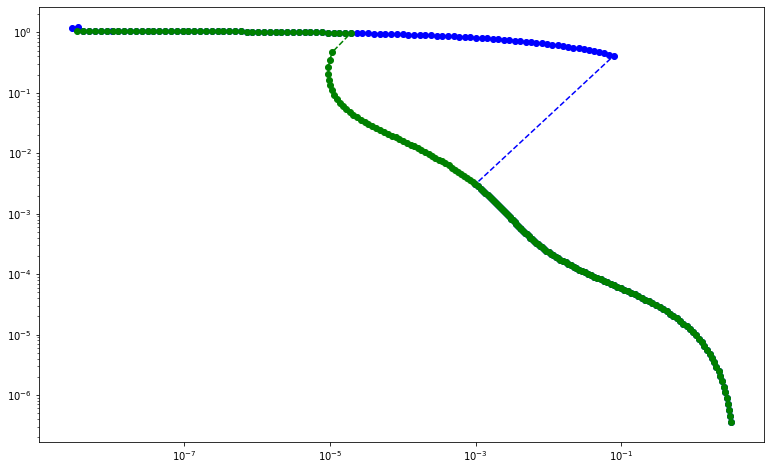

In [25]:
plt.loglog(*fsvals.T, 'bo--')
plt.loglog(*fsvalsbp.T, 'go--')

Text(0, 0.5, '$|| y-c\\Phi ||$')

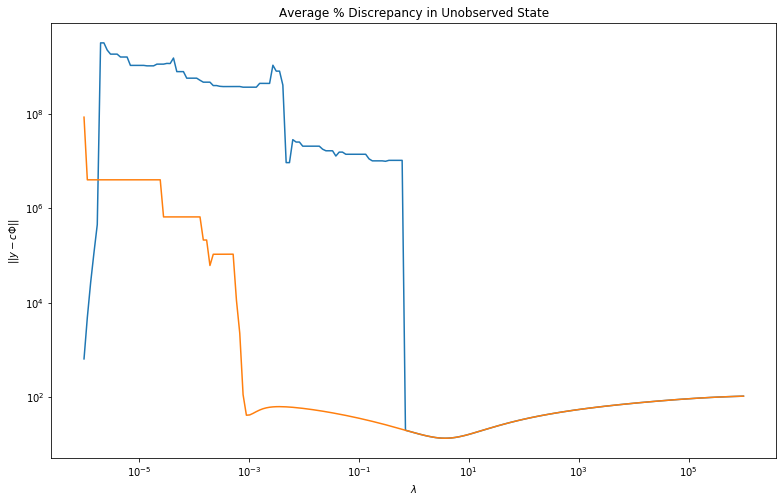

In [26]:
cvfnbp = lambda idx : np.sqrt(np.sum(((np.array(getx(solutionsbp[idx]['x'])[1]).flatten()) - sol.sol(model.observation_times)[1])**2)/len(model.observation_times))
validationbp = [100*cvfnbp(i)/np.mean(np.abs(sol.sol(model.observation_times)[1])) for i in range(200)]
# idx = 115
plt.loglog(prange, validation)
plt.loglog(prangebp, validationbp)
# plt.loglog(prange[idx], validation[idx], 'ro')
plt.title("Average % Discrepancy in Unobserved State")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$|| y-c\Phi ||$")

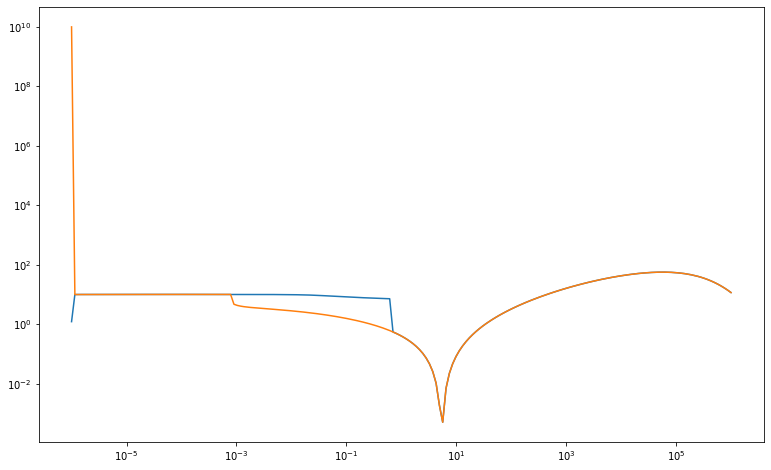

In [27]:
pwrongnessbp = lambda idx: np.sum((np.array(p_true) - np.array(getp(solutionsbp[idx]['x'])))**2)
perrbp = [pwrongnessbp(i) for i in range(200)]
plt.loglog(prange, perr)
plt.loglog(prangebp, perrbp)
